<center><img src='https://www.fda.gov/files/Coronavirus_3D_illustration_by_CDC_1600x900.png' style="width: 800px;"/></center>

<center><strong><font size="10">U.S. Covid-19 Analysis and Prediction</font></strong></center>

<center><em>Zhe Wang</em></center>
<center><em>For more information about me, visit<a href='https://github.com/jerrywang0928'> https://github.com/jerrywang0928</a></em></center>

# Introdutction

Coronavirus disease 2019 (COVID‑19) is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). It was first identified in December 2019 in Wuhan, Hubei, China, and has resulted in an ongoing pandemic. As of 16 September 2020, more than 268 million cases have been reported across 188 countries and territories with more than 5 million deaths; more than 241 million people have recovered.

This analysis is primarily focused on U.S. Covid-19 Cases. By plotting and analyzing dataset provided by NYtimes, we will have a closer look at the trend, seasonality and make a proper prediction on total number of U.S. cases using ARIMA model.


Feel free to check the dataset here: https://github.com/nytimes/covid-19-datamIn 

# Import Packages

In [119]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [120]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Load Dataset

In [121]:
states_data = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')

In [122]:
us_data = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv')

In [123]:
us_data.head()

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0


In [124]:
# Calculate fatality rate
for i in states_data['deaths']:
    if i == 0:
        states_data['fatality_rate%'] = 0 
    else:
        states_data['fatality_rate%'] = 100*states_data['deaths']/states_data['cases']     

In [125]:
states_data.head()

,date,state,fips,cases,deaths,fatality_rate%
0,2020-01-21,Washington,53,1,0,0.0
1,2020-01-22,Washington,53,1,0,0.0
2,2020-01-23,Washington,53,1,0,0.0
3,2020-01-24,Illinois,17,1,0,0.0
4,2020-01-24,Washington,53,1,0,0.0


In [126]:
states_data.isna().sum()

date              0
state             0
fips              0
cases             0
deaths            0
fatality_rate%    0
dtype: int64

# EDA

In [127]:
px.bar(data_frame=us_data, y=['cases','deaths'],x='date',title = '<b>Cases and deaths in U.S.<b>')

By 2021-12-7, total confirmed cases in US is **49,356,263**, total deaths is **790,082**, fatility rate is **1.6%**. <br>
Notice that there is a stiff increse from **Oct 2020 to Feb 2021**, the reason behind this is the weather got colder and drier. According an <a href='https://www.forbes.com/sites/brucelee/2021/11/22/covid-19-cases-increase-by-161-raising-concerns-of-winter-delta-surge/?sh=5e36d552130darticel'>article</a> in Forbes, a digital enior health expert says: "Such conditions could potentially help the virus survive longer, affect the size and composition of virus-carrying respiratory droplets, and hamper your respiratory tract’s defenses. Winter conditions will also move more activities indoors where it may be harder to social distance and maintain good air circulation and ventilation." <br>
We can confirm above conclustion as we can see there is a clear increasing trend now since the current winter season. People should definetly pay more attention.

In [128]:
# Create states plot
state = states_data[states_data['date']==states_data['date'].max()].sort_values(by='cases',ascending=False)
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Bar(x=state['state'], y=state['cases'], name="cases"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=state['state'], y=state['fatality_rate%'], name="fatality_rate"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="<b>Cases and Fatality Rate of each State<b> (Feel free to zoom in)"
)

# Set x-axis title
fig.update_xaxes(title_text="Sate")

# Set y-axes titles
fig.update_yaxes(title_text="Cases", secondary_y=False)
fig.update_yaxes(title_text="Fatality Rate%", secondary_y=True)

fig.show()

Notice that New Jersy, New York, Massachusetts and Connecticut have the highest fatility rate **(All greater than 2.0%)** compared to other big states. We can consider all of them as **the Big New York Metropolitan Area**. On the other hand, North Carolina has relatively low fatility rate of **1.21** compared to its confirmed cases. It is reasonalble to believe location and density of population plays a big role here. New York City is the densest metropolitan area in the U.S. with populations above 100,000. With such close quarters, it seems likely that a virus would spread faster there compared with a rural or even a less-dense city.

## U.S. daily new cases

In [129]:
#Feature engineering in order to get new cases column
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'
df['lag_one'] = df.cases.shift(1)
df['new_cases'] = df['cases'] - df['lag_one']
df = df[['new_cases']].iloc[1:]
df.head()

,new_cases
date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,1.0
2020-01-26,2.0


In [130]:
px.line(df, title = '<b>U.S. Daily New Cases<b> (Feel free to zoom in)')

If we zoom in, we can see a clearly interesting week seassonality, there is big increse during the weekday compared to the weekends. For example, on 2021-11-28 which is a Sunday, the number of new cases is 23950. However, on the next day 2021-11-29 which is a Monday, the number of new cases is 216312, 9 times more than Sunday! My own answer is because test center are closed in weekends, but it still would be a good feature to consider for later modeling

# ETS Decomposition for the U.S. Dataset

In [131]:
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'
df = df[['cases']]
df

,cases
date,
2020-01-21,1
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,3
...,...
2021-12-04,49010250
2021-12-05,49044822
2021-12-06,49242271


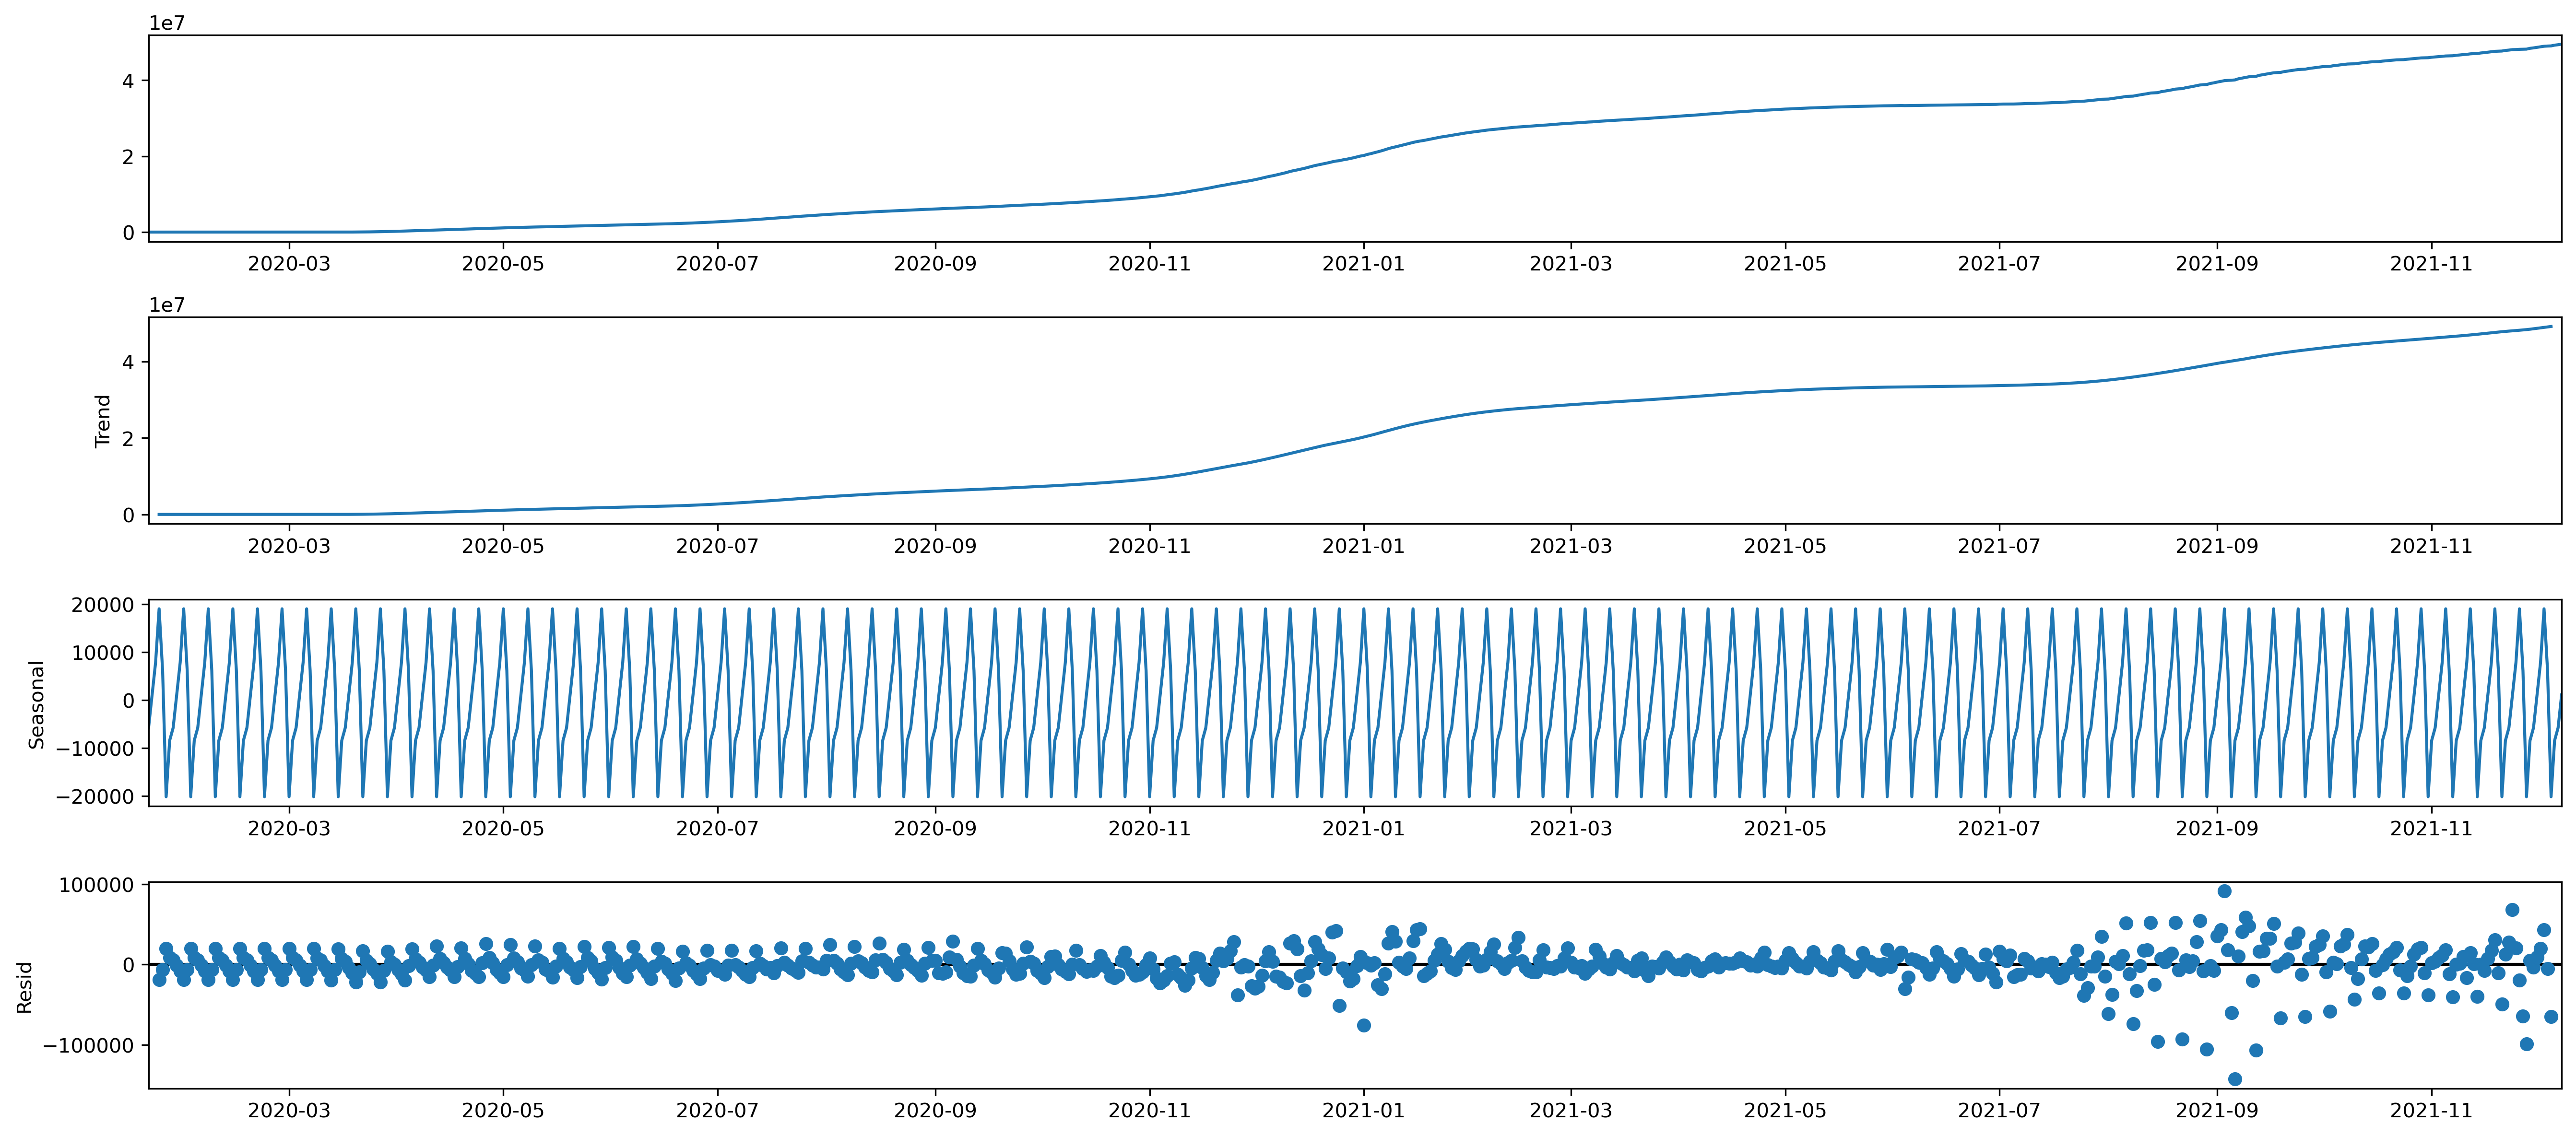

In [132]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
plt.rcParams['figure.dpi'] = 300
decomposition = seasonal_decompose(df,model='additive')
fig = decomposition.plot()
plt.show()

Here we see that the seasonal component does not contribute significantly to the behavior of the series.


# Time Series Analysis

## SMA - Simple Moving Average

In [133]:
df['50-days-SMA'] = df['cases'].rolling(window=50).mean()
df['100-days-SMA'] = df['cases'].rolling(window=100).mean()

In [134]:
df

,cases,50-days-SMA,100-days-SMA
date,,,
2020-01-21,1,NaN,NaN
2020-01-22,1,NaN,NaN
2020-01-23,1,NaN,NaN
2020-01-24,2,NaN,NaN
2020-01-25,3,NaN,NaN
...,...,...,...
2021-12-04,49010250,46800205.62,44456489.90
2021-12-05,49044822,46883247.92,44559452.53
2021-12-06,49242271,46969796.16,44663537.06


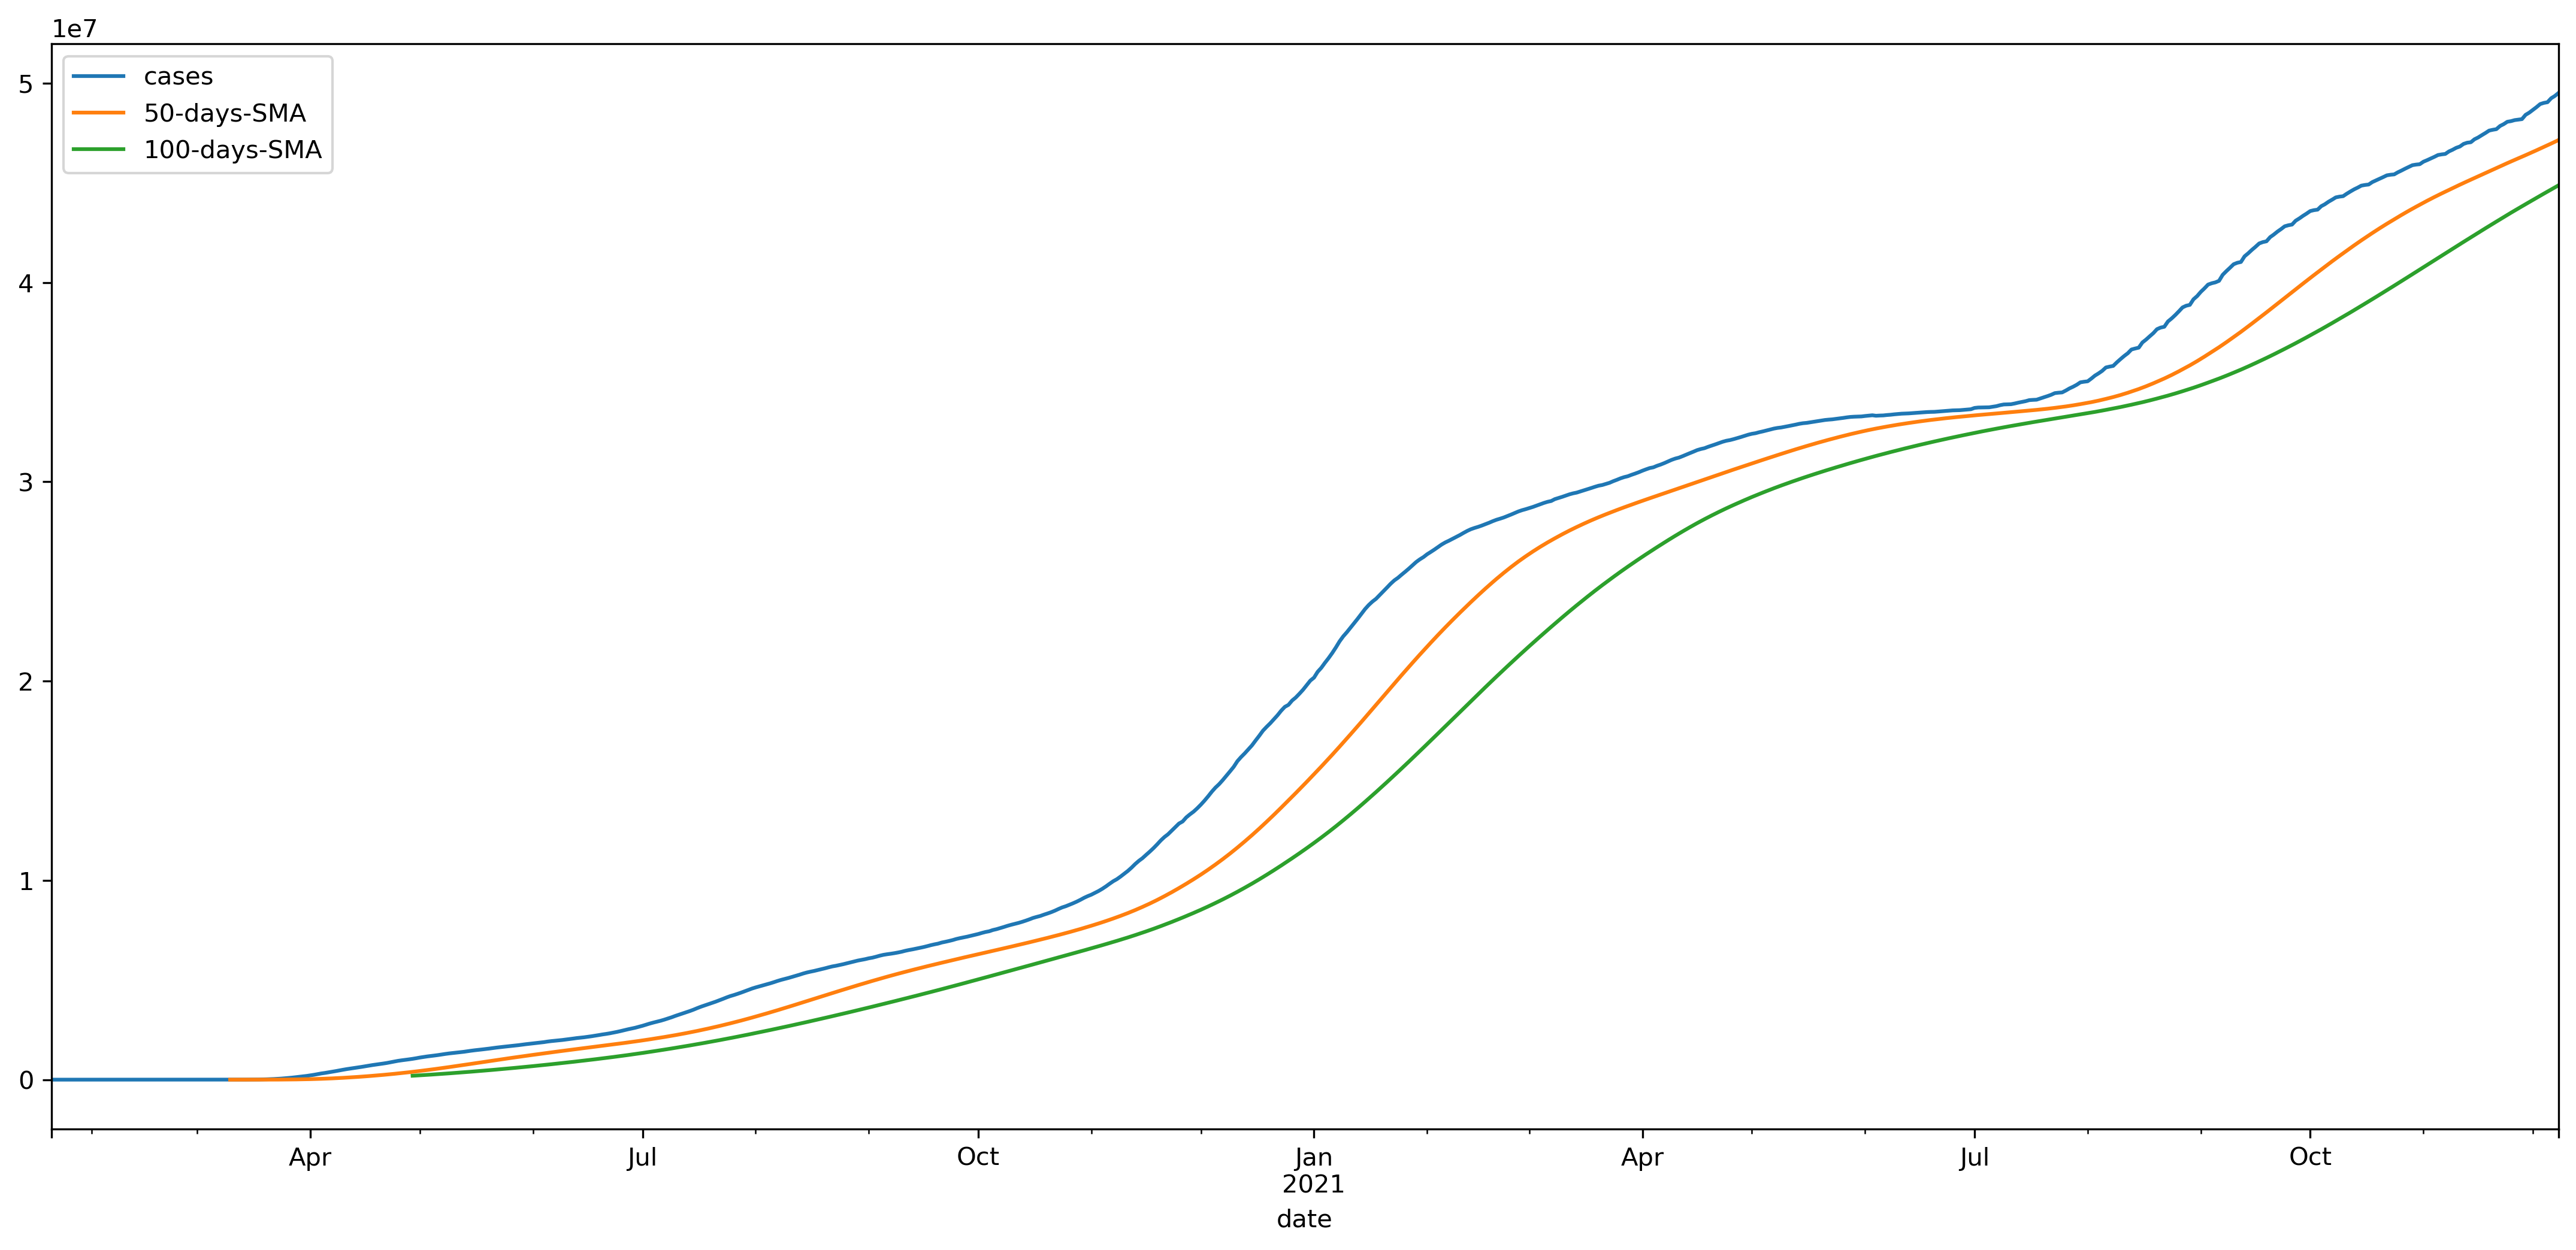

In [135]:
df.plot()

## EWMA - Exponentially Weighted Moving Average 

Math Function:<br>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

In [136]:
df['EWMA100'] = df['cases'].ewm(span=100,adjust=False).mean()

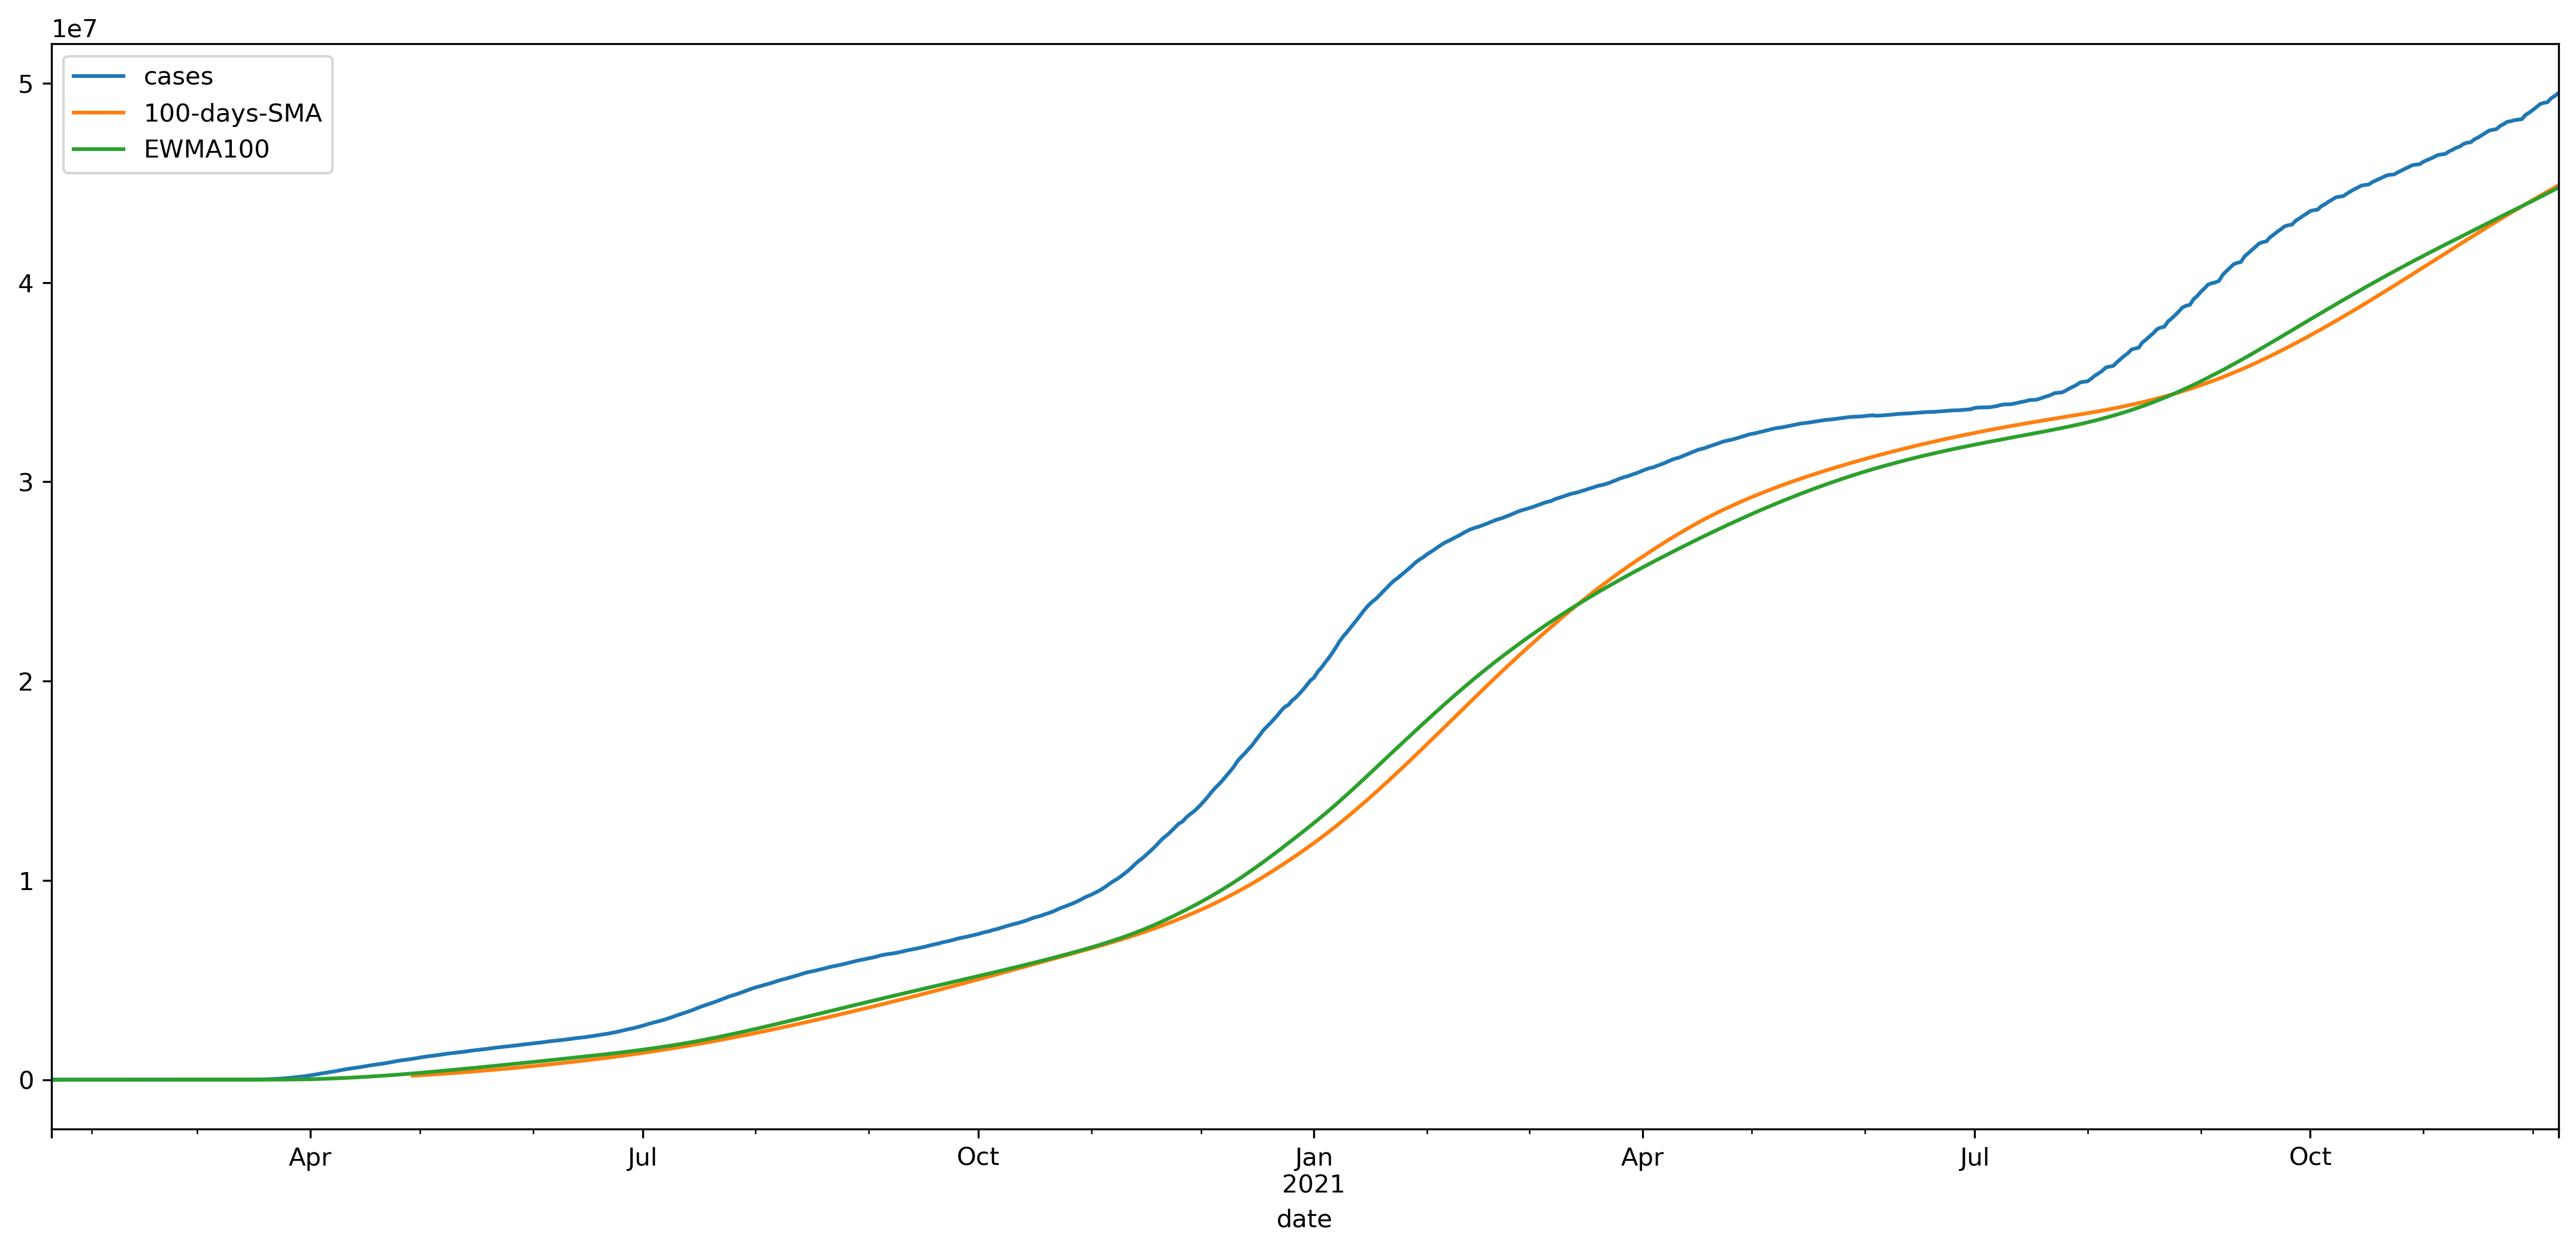

In [137]:
df[['cases','100-days-SMA','EWMA100']].plot()

Notice we also have data for first 100 days, which solves the issues that SMA has.

The performances are pretty much the same, but the result was still not satisfactory.

Next we will consider the trend and use Double Exponential Smoothin

## Double Exponential Smoothing

In [138]:
# DESadd100 means Double Exponetial Smooting and additive method
df['DESadd100'] = ExponentialSmoothing(df['cases'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,cases,50-days-SMA,100-days-SMA,EWMA100,DESadd100
date,,,,,
2020-01-21,1,NaN,NaN,1.000000,1.000000
2020-01-22,1,NaN,NaN,1.000000,1.000000
2020-01-23,1,NaN,NaN,1.000000,1.000000
2020-01-24,2,NaN,NaN,1.019802,2.207148
2020-01-25,3,NaN,NaN,1.059014,3.376386


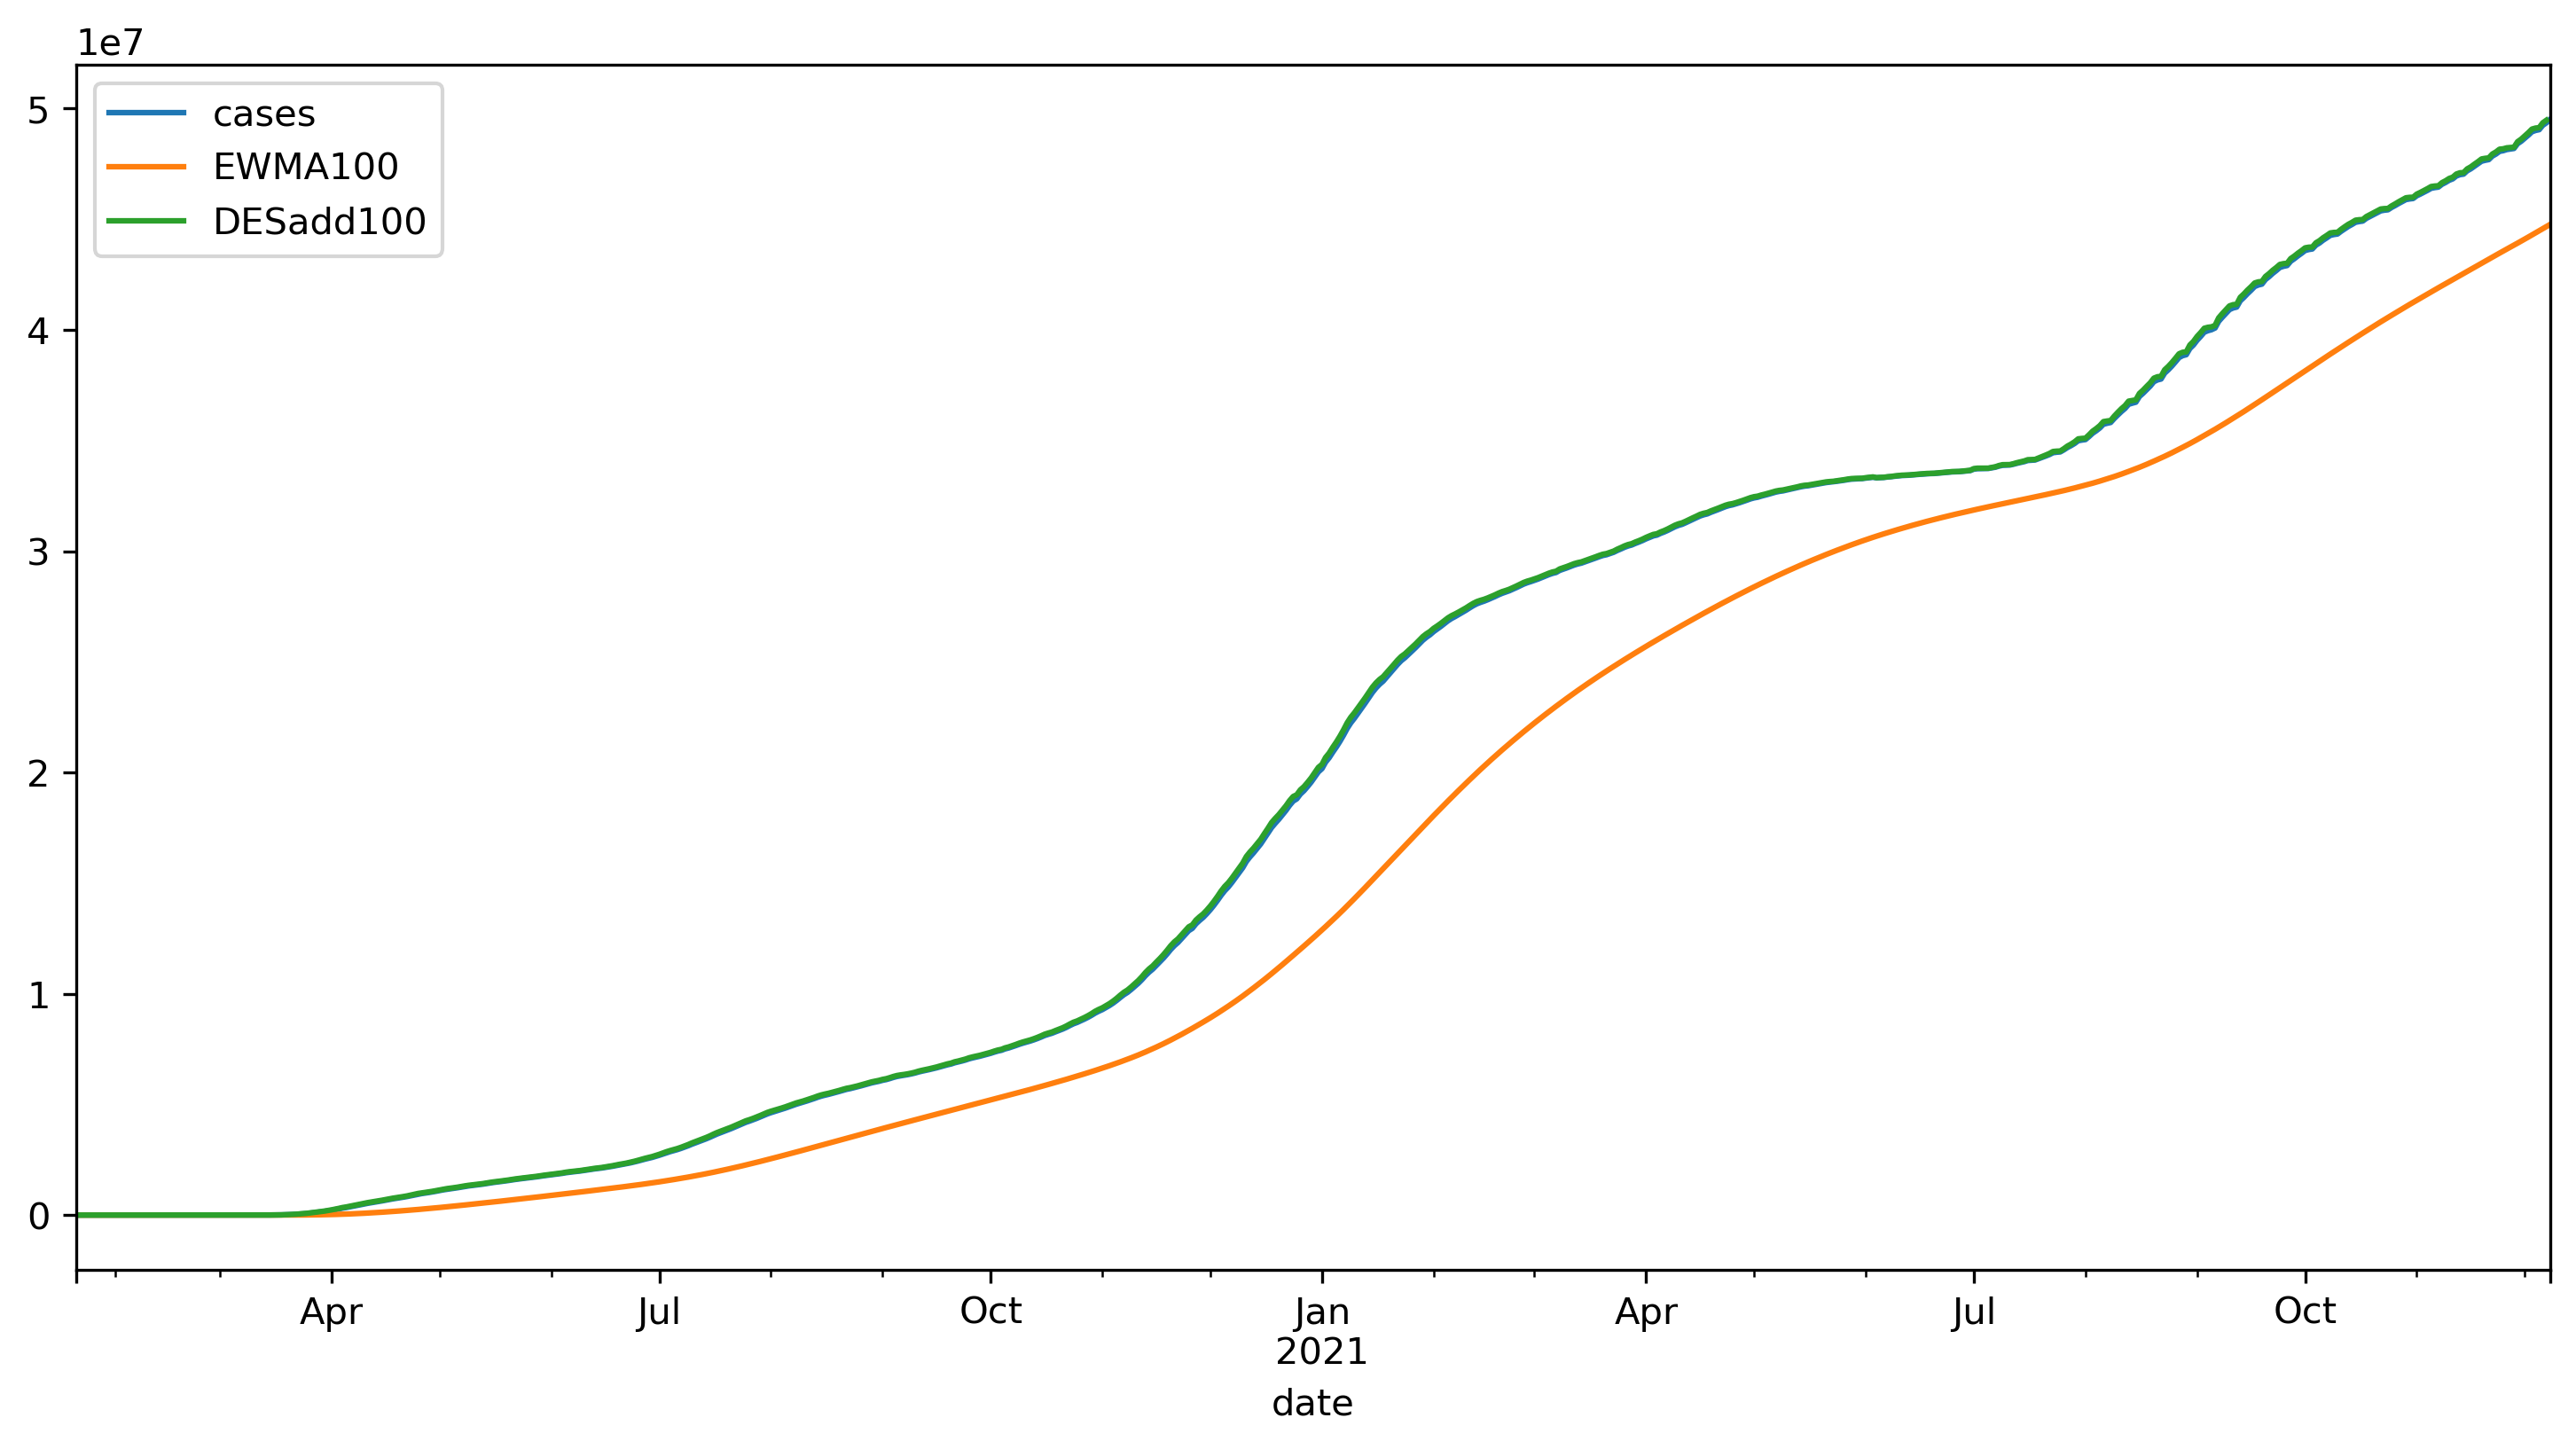

In [139]:
df[['cases','EWMA100','DESadd100']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

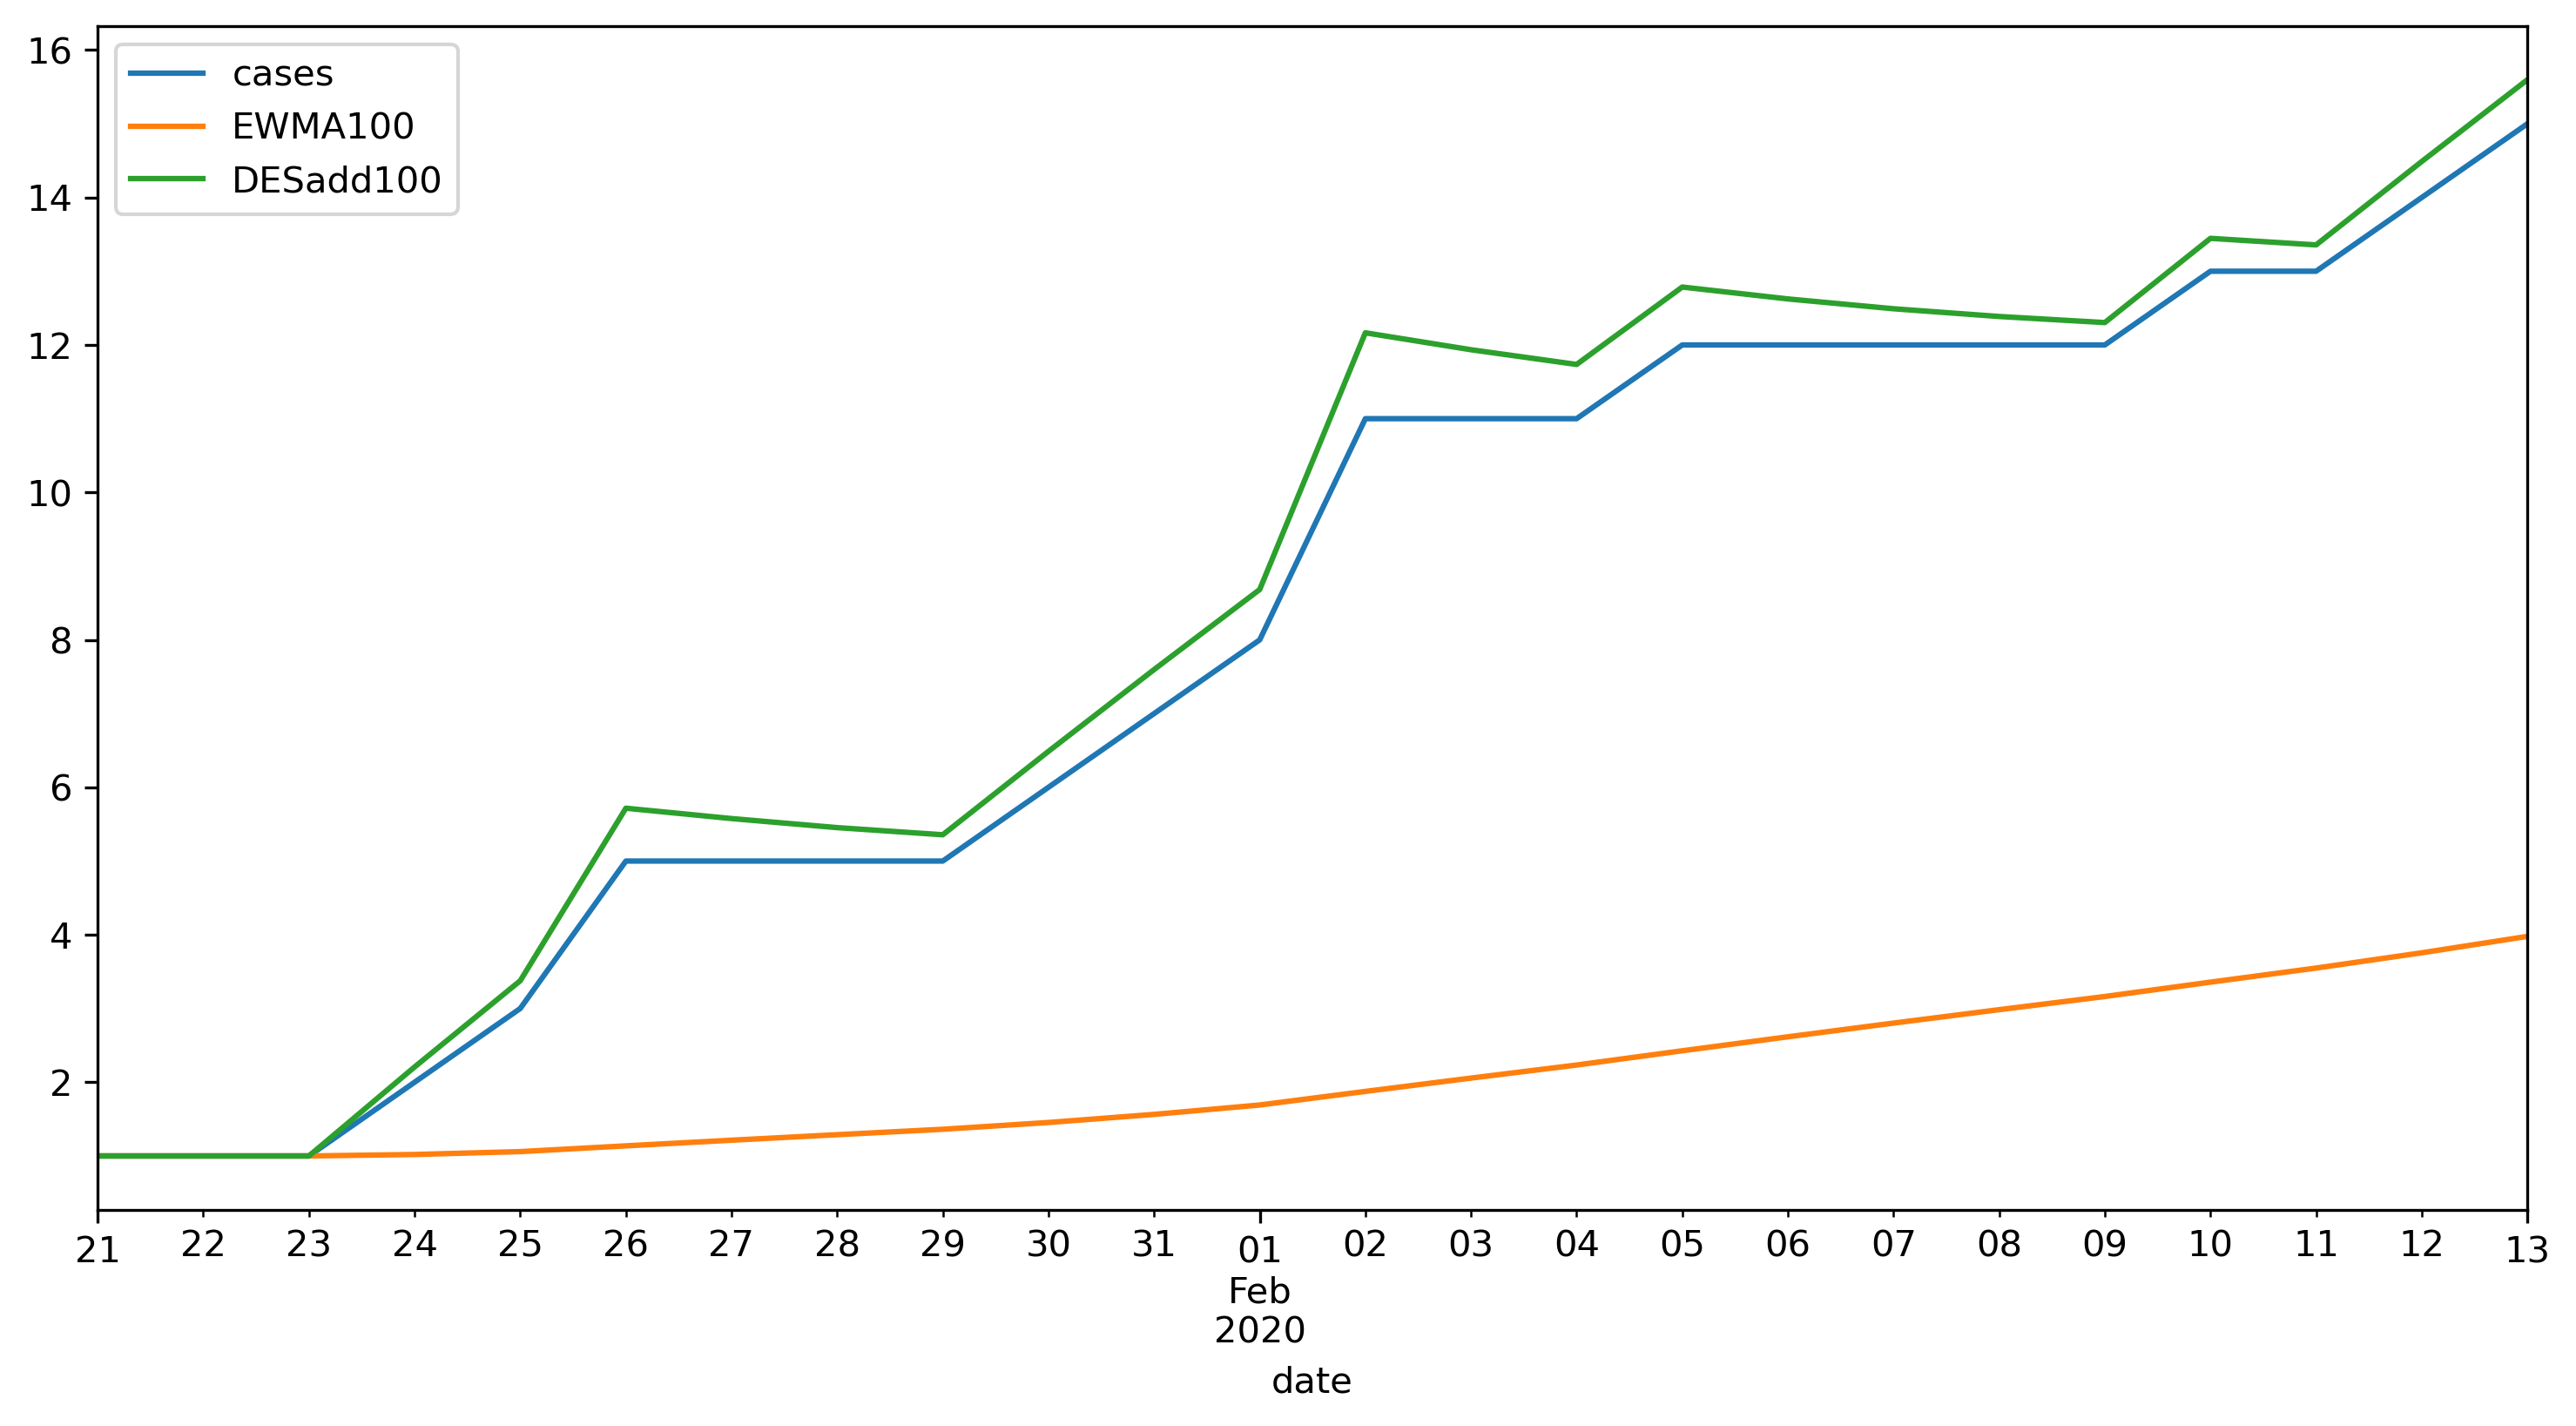

In [140]:
# Let's take a closer look (only first 24 days)
df[['cases','EWMA100','DESadd100']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Notice Double Exponential Smoothing is a much better representation of the time series data <br>
Now let's try we multiplicative and compare

In [141]:
# DESmul100 means Double Exponetial Smooting and mul method
df['DESmul100'] = ExponentialSmoothing(df['cases'], trend='multiplicative').fit().fittedvalues.shift(-1)
df.head()

,cases,50-days-SMA,100-days-SMA,EWMA100,DESadd100,DESmul100
date,,,,,,
2020-01-21,1,NaN,NaN,1.000000,1.000000,1.000000
2020-01-22,1,NaN,NaN,1.000000,1.000000,1.000000
2020-01-23,1,NaN,NaN,1.000000,1.000000,1.000000
2020-01-24,2,NaN,NaN,1.019802,2.207148,2.465262
2020-01-25,3,NaN,NaN,1.059014,3.376386,3.893235


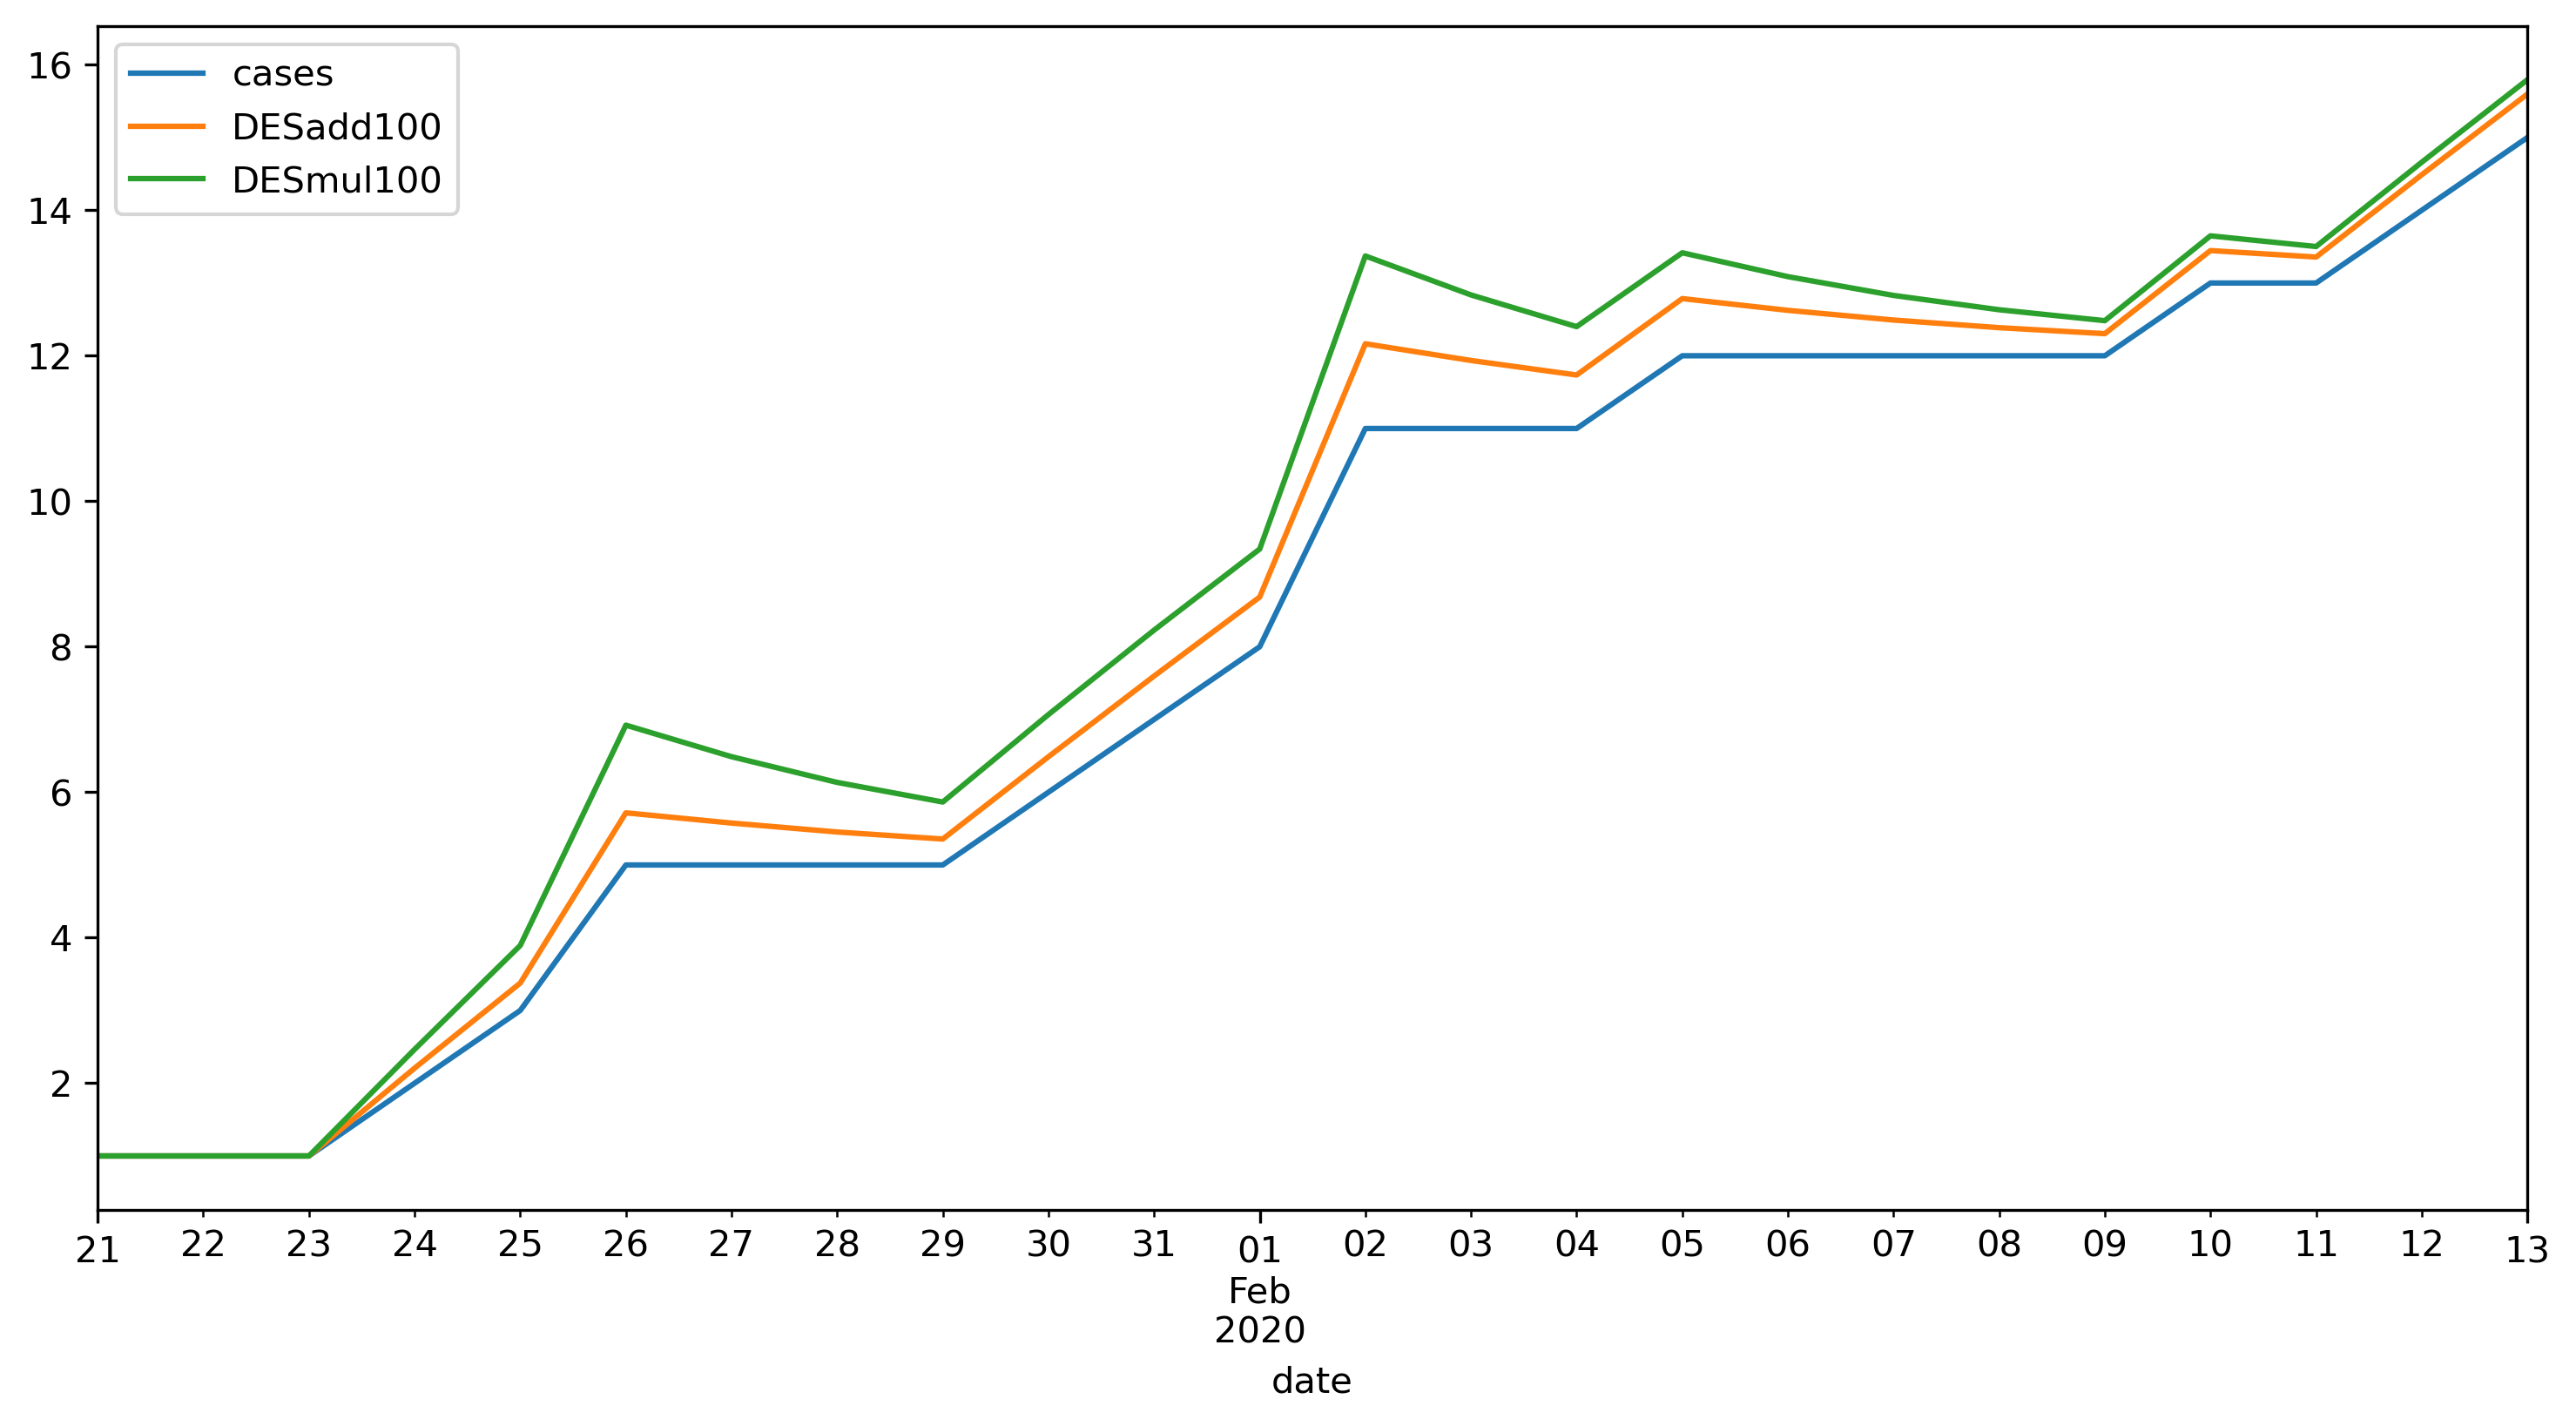

In [142]:
df[['cases','DESadd100','DESmul100']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

We can see that the additive method is closer to our orginal data, which indicates it's a better result

# Model Building

Since we have the analysis above, we will go with Double Exponential Smoothing directly

## Double Exponential Smoothing Model

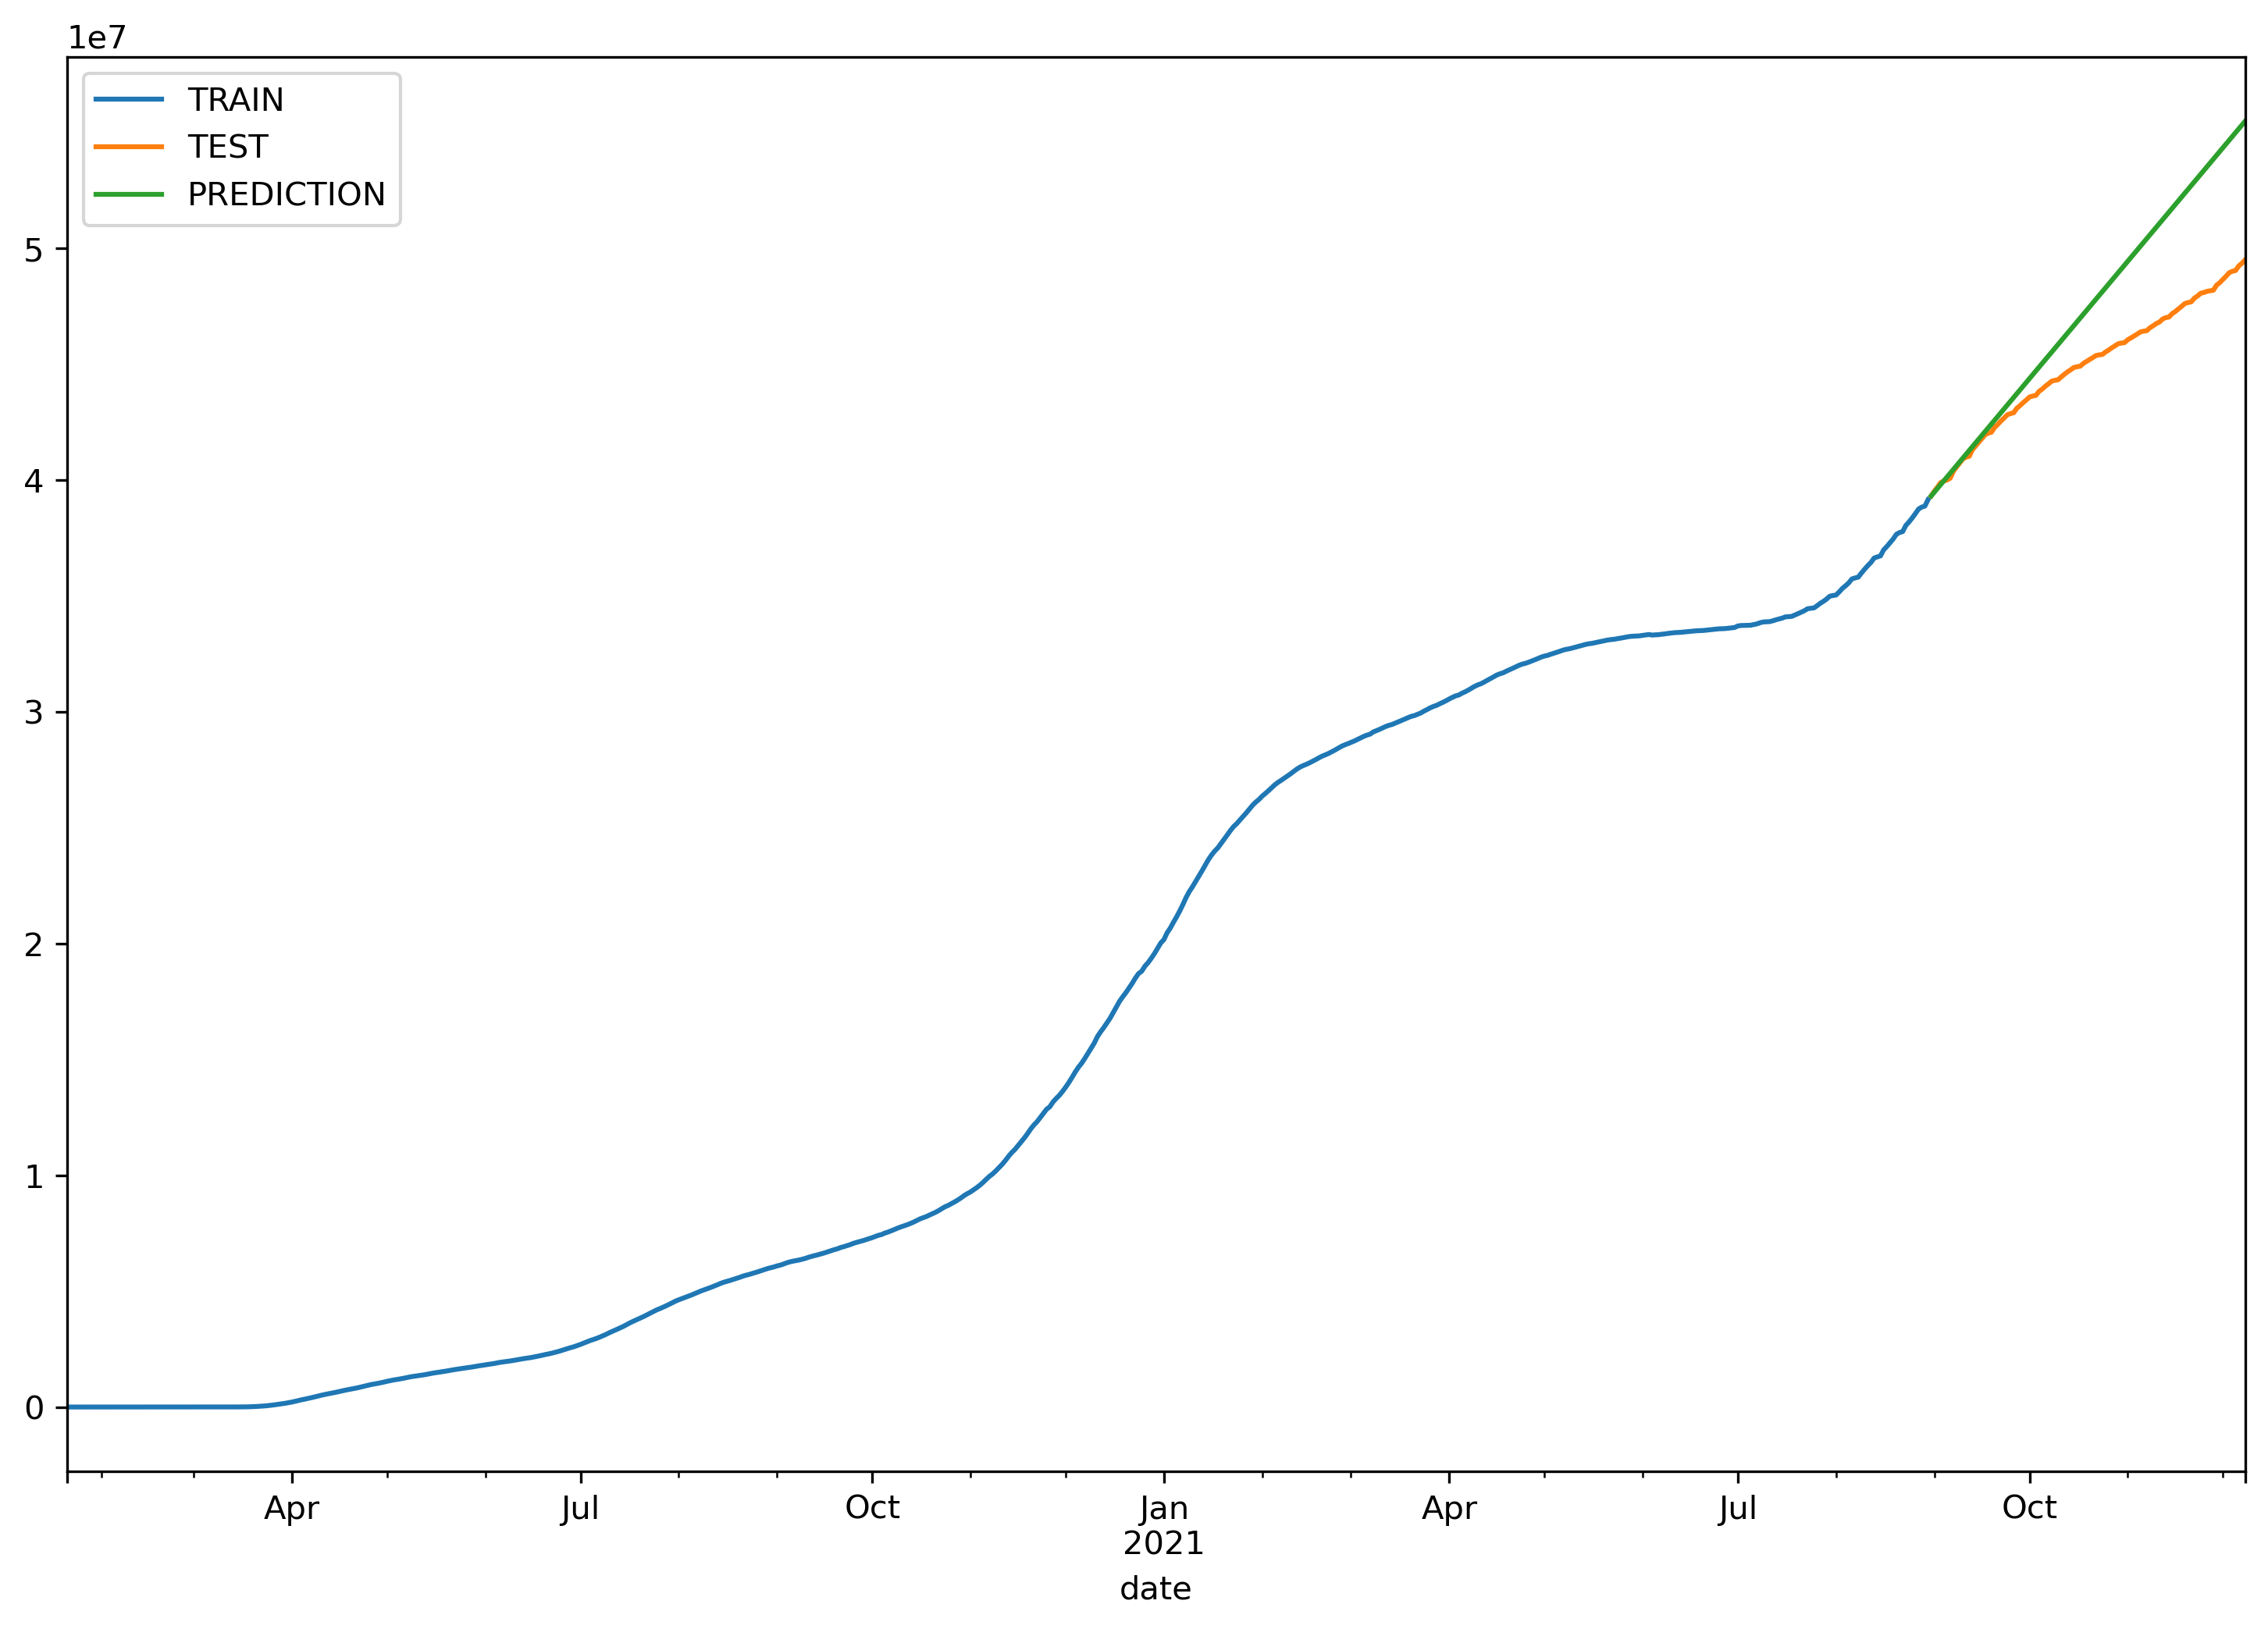

In [143]:
# choose 100 days as test
train_data = df.iloc[:-100] 
test_data = df.iloc[-100:]
fitted_model = ExponentialSmoothing(train_data['cases'],trend='add').fit()
test_predictions = fitted_model.forecast(100)
train_data['cases'].plot(legend=True,label='TRAIN')
test_data['cases'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

It seems like there is a dampe as the time goes on, which totally makes sense, since there will be less and less cases eventually. So let's use a damped method to fit the model

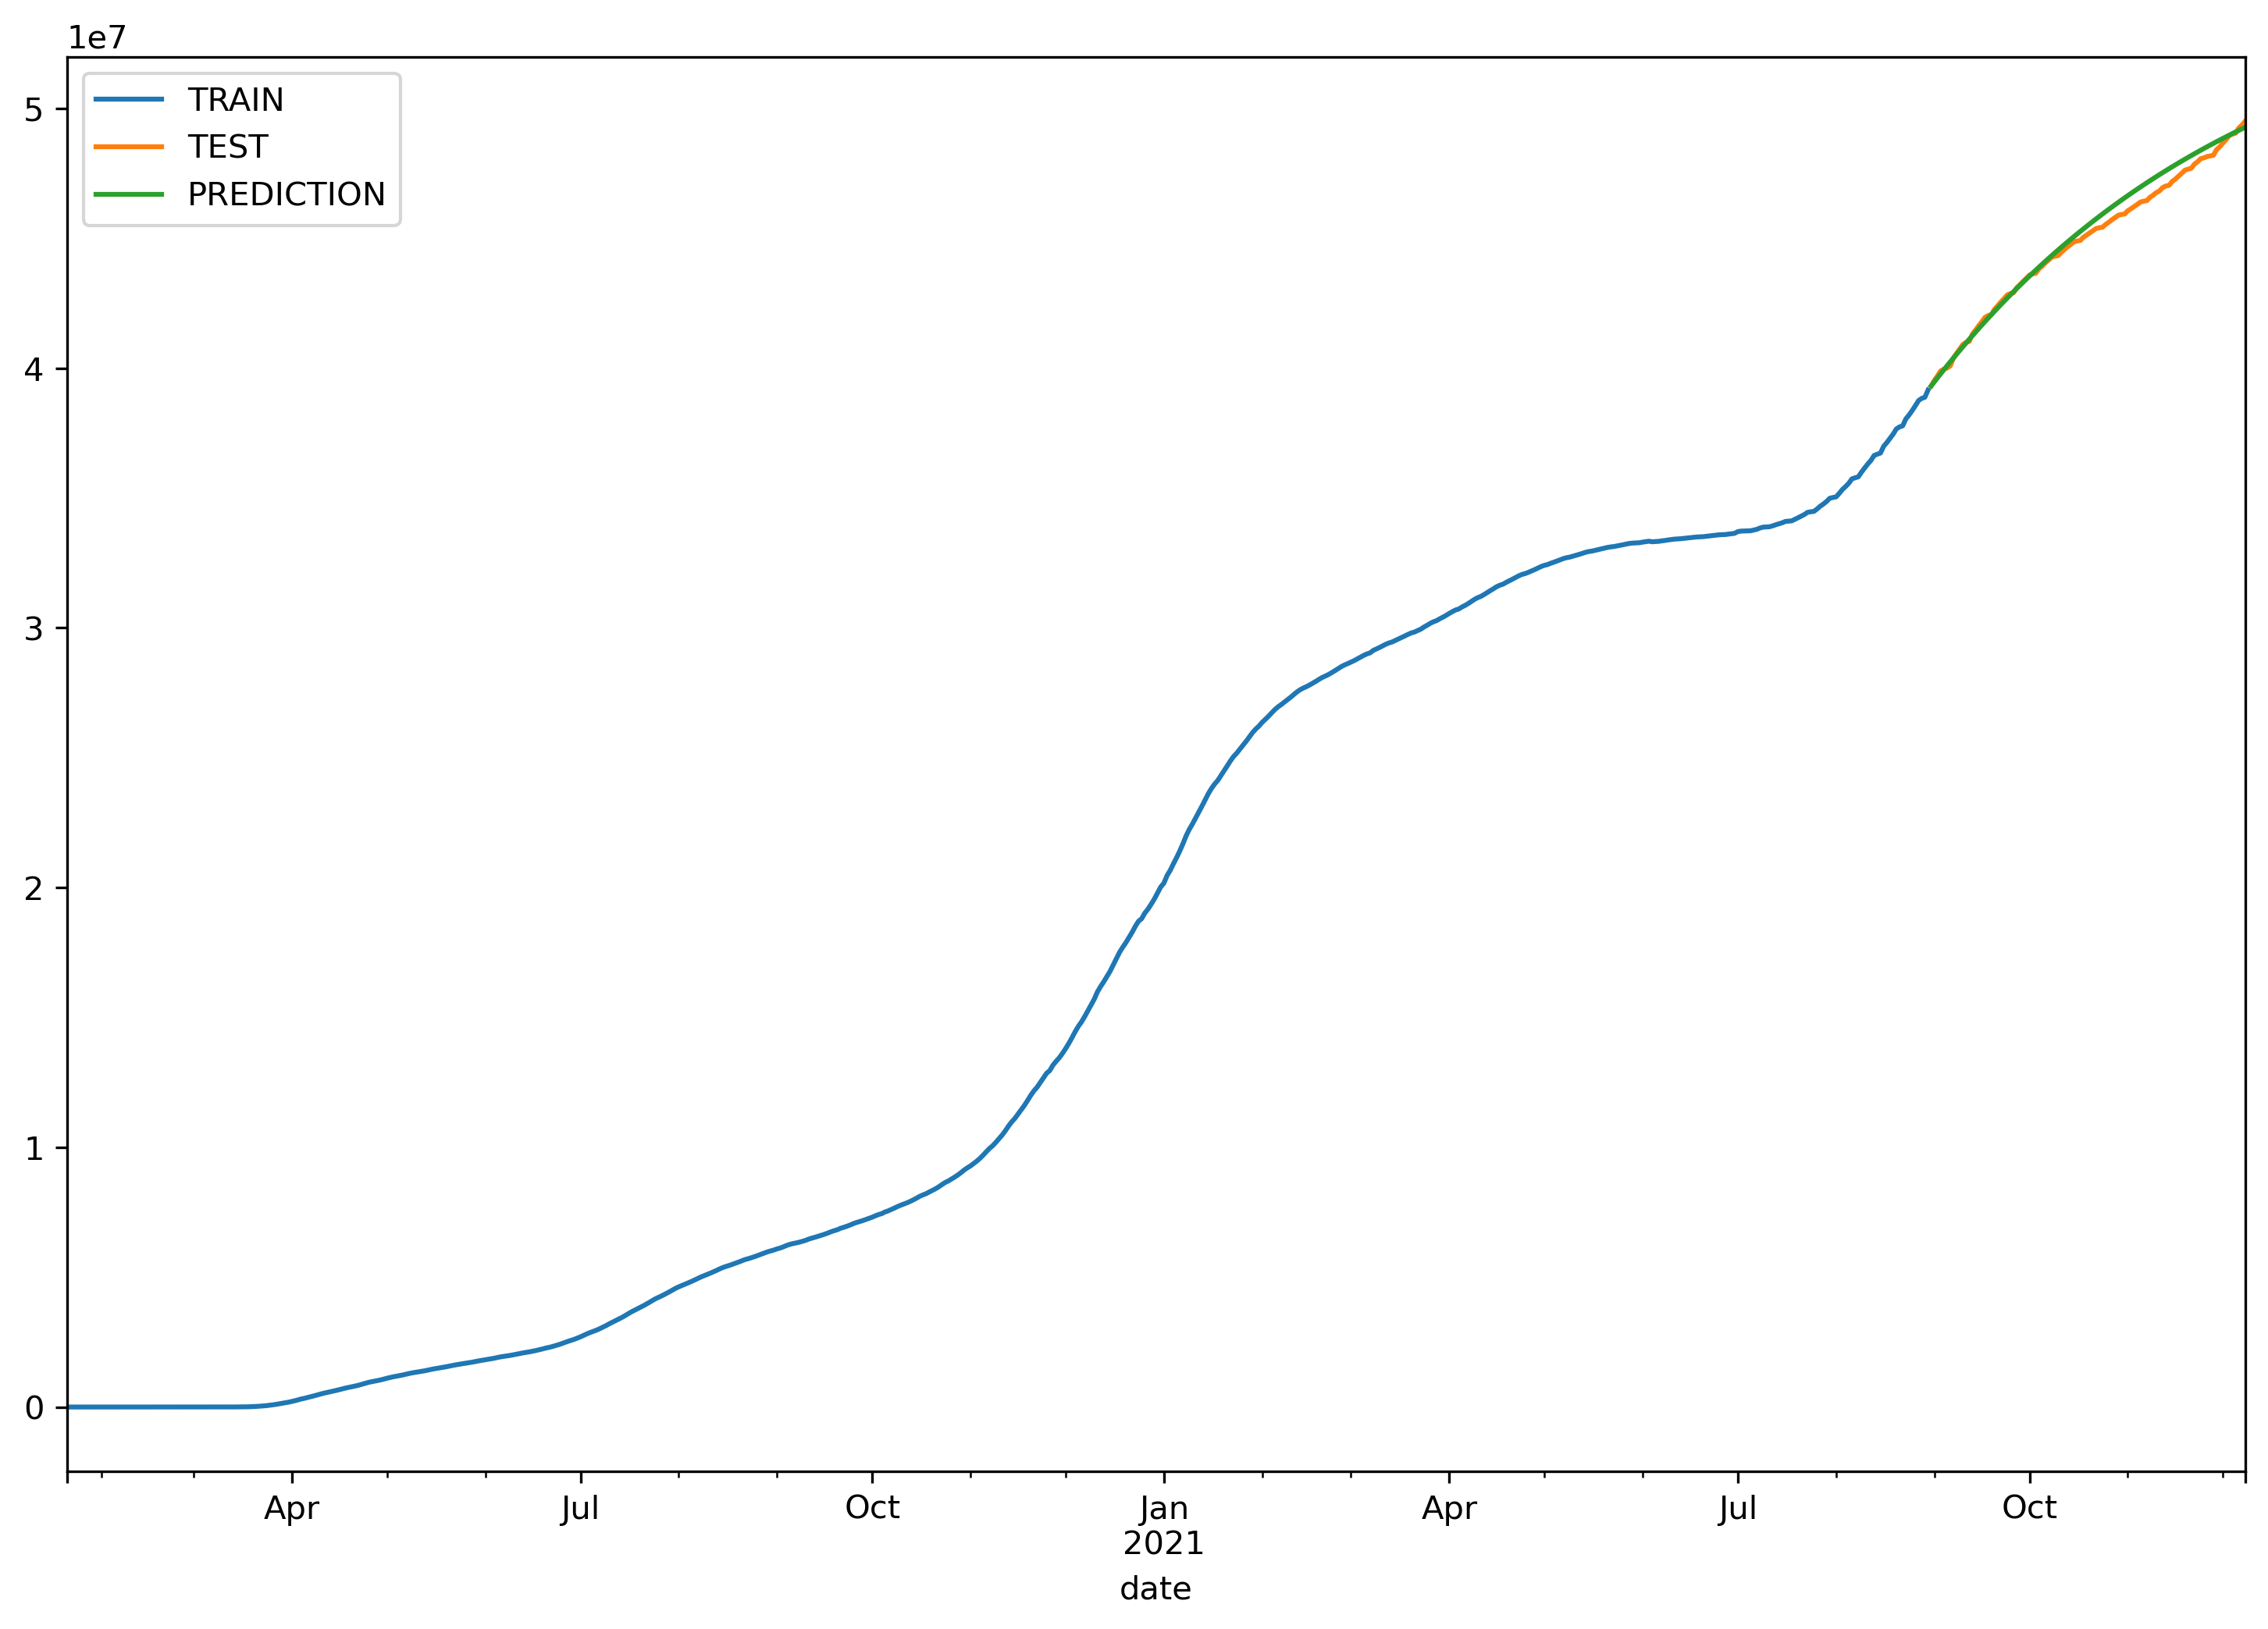

In [144]:
fitted_model = ExponentialSmoothing(train_data['cases'],trend='add',damped_trend=True).fit()
test_predictions = fitted_model.forecast(100)
train_data['cases'].plot(legend=True,label='TRAIN')
test_data['cases'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

We can just eyeball it that it's a much better fit

In [149]:
test_data

,cases,50-days-SMA,100-days-SMA,EWMA100,DESadd100,DESmul100
date,,,,,,
2021-08-31,39316629,36054094.32,34780372.21,3.495011e+07,3.947721e+07,3.948118e+07
2021-09-01,39527624,36165242.90,34844074.33,3.504076e+07,3.969865e+07,3.970381e+07
2021-09-02,39703320,36279144.30,34909305.03,3.513309e+07,3.987556e+07,3.988041e+07
2021-09-03,39894795,36396154.84,34976216.62,3.522738e+07,4.007105e+07,4.007607e+07
2021-09-04,39960849,36513441.98,35043511.28,3.532111e+07,4.011437e+07,4.011587e+07
...,...,...,...,...,...,...
2021-12-04,49010250,46800205.62,44456489.90,4.438255e+07,4.911798e+07,4.911981e+07
2021-12-05,49044822,46883247.92,44559452.53,4.447487e+07,4.913709e+07,4.913681e+07
2021-12-06,49242271,46969796.16,44663537.06,4.456928e+07,4.935596e+07,4.935869e+07


### Evaluation Metrics

In [151]:
error = int(np.sqrt(mean_squared_error(test_data.cases,test_predictions)))
mean = int(test_data.cases.mean())
error_rate = round((error/mean),5)
print(f'Error for test data is: {error}\n\
Mean for test data is: {mean}\n\
Error Rate is: {error_rate}\n')

Error for test data is: 346206
Mean for test data is: 44871829
Error Rate is: 0.00772



Notice the error rate is low, but we are not sure whether it's overfit or not by now

### Retrain the model and Forecast into Future

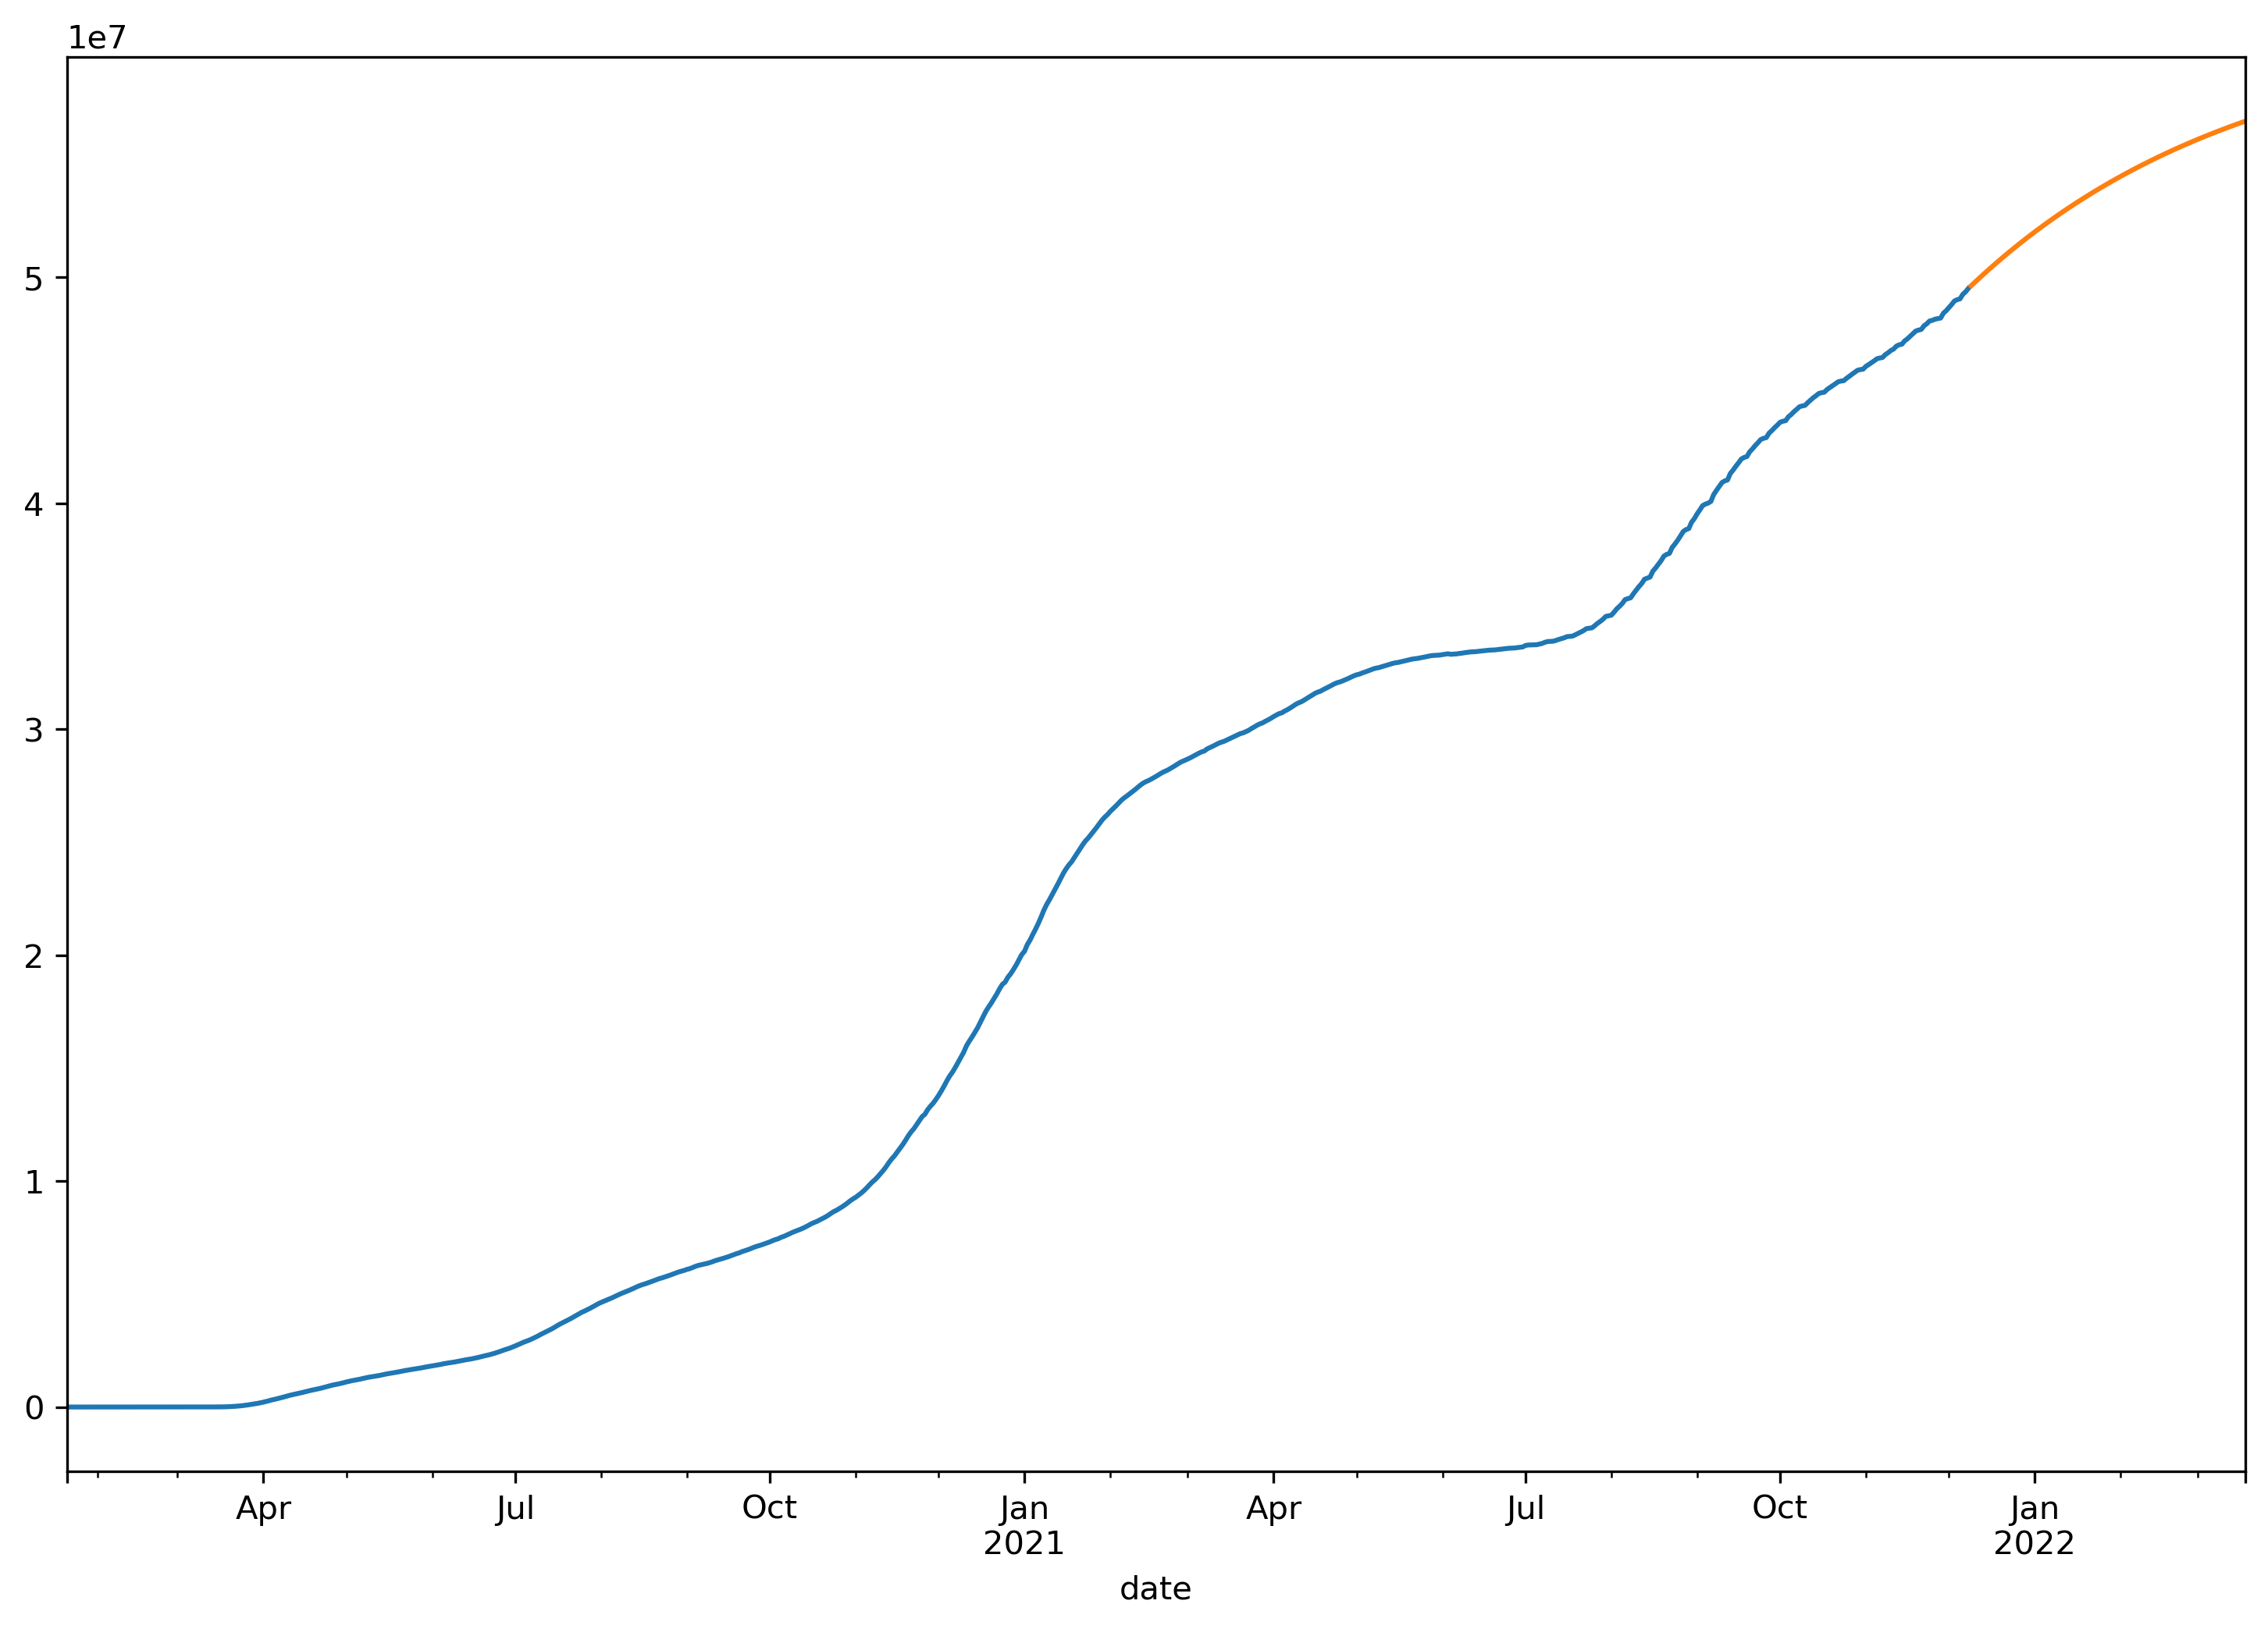

In [152]:
final_model = ExponentialSmoothing(df['cases'],trend='add',damped_trend=True).fit()
forecast_predictions = final_model.forecast(100)
df['cases'].plot(figsize=(12,8))
forecast_predictions.plot();

It seems make sense now, then let's move to ARIMA model

## ARIMA

In [153]:
# Import Data again
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'
df = df[['cases']]
df.head()

,cases
date,
2020-01-21,1
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,3


### Check stationarity

Write a function that performs the augmented Dickey-Fuller Test.

In [154]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and" + color.BOLD + color.RED +" Stationary" + color.END)
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is" + color.BOLD + color.RED +" Non-Stationary" + color.END)

In [155]:
adf_test(df['cases'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.139522
p-value                   0.945357
# lags used              16.000000
# observations          671.000000
critical value (1%)      -3.440133
critical value (5%)      -2.865857
critical value (10%)     -2.569069
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is Non-Stationary


### Use <tt>pmdarima.auto_arima</tt> to determine ARIMA Orders

In [156]:
stepwise_fit = auto_arima(df['cases'], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=3,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=16453.466, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=16341.400, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=16151.107, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=16451.490, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=16151.038, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=16135.457, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=16244.000, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=16135.021, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=16209.956, Time=0.07 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=16234.396, Time=0.30 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=16066.909, Time=0.41 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=16136.552, Time=0.23 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=16025.822, Time=0.75 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=16112.191, Time=0.35 sec
 ARIMA(3,2,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  688
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -8001.778
Date:                Thu, 09 Dec 2021   AIC                          16017.556
Time:                        16:46:10   BIC                          16049.272
Sample:                             0   HQIC                         16029.828
                                - 688                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1712      0.050     -3.396      0.001      -0.270      -0.072
ar.L2         -0.8714      0.026    -33.270      0.000      -0.923      -0.820
ar.L3          0.2343      0.049      4.760      0.000       0.138       0.331
ma.L1         -0.5282      0.043    -12.290      0.000      -0.612      -0.444
ma.L2          0.6995      0.022     32.449      0.000       0.657       0.742
ma.L3         -0.7459      0.032    -22.988      0.000      -0.810      -0.682
sigma2      9.994e+08   8.98e-12   1.11e+20      0.000    9.99e+08    9.99e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1599.70
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              72.28   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  5e+35. Standard errors may be unstable.
"""

This suggests that we should fit an <strong>ARIMA(3,2,3)</strong> model to best forecast future values of the series.

### Difference 3 times and Check stationarity again

In [157]:
from statsmodels.tsa.statespace.tools import diff
df['cases_diff3'] = diff(df['cases'],k_diff=3)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df['cases_diff3'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic     -9.819868e+00
p-value                 5.373763e-17
# lags used             2.000000e+01
# observations          6.640000e+02
critical value (1%)    -3.440237e+00
critical value (5%)    -2.865903e+00
critical value (10%)   -2.569093e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and Stationary


### Run the ACF and PACF plots

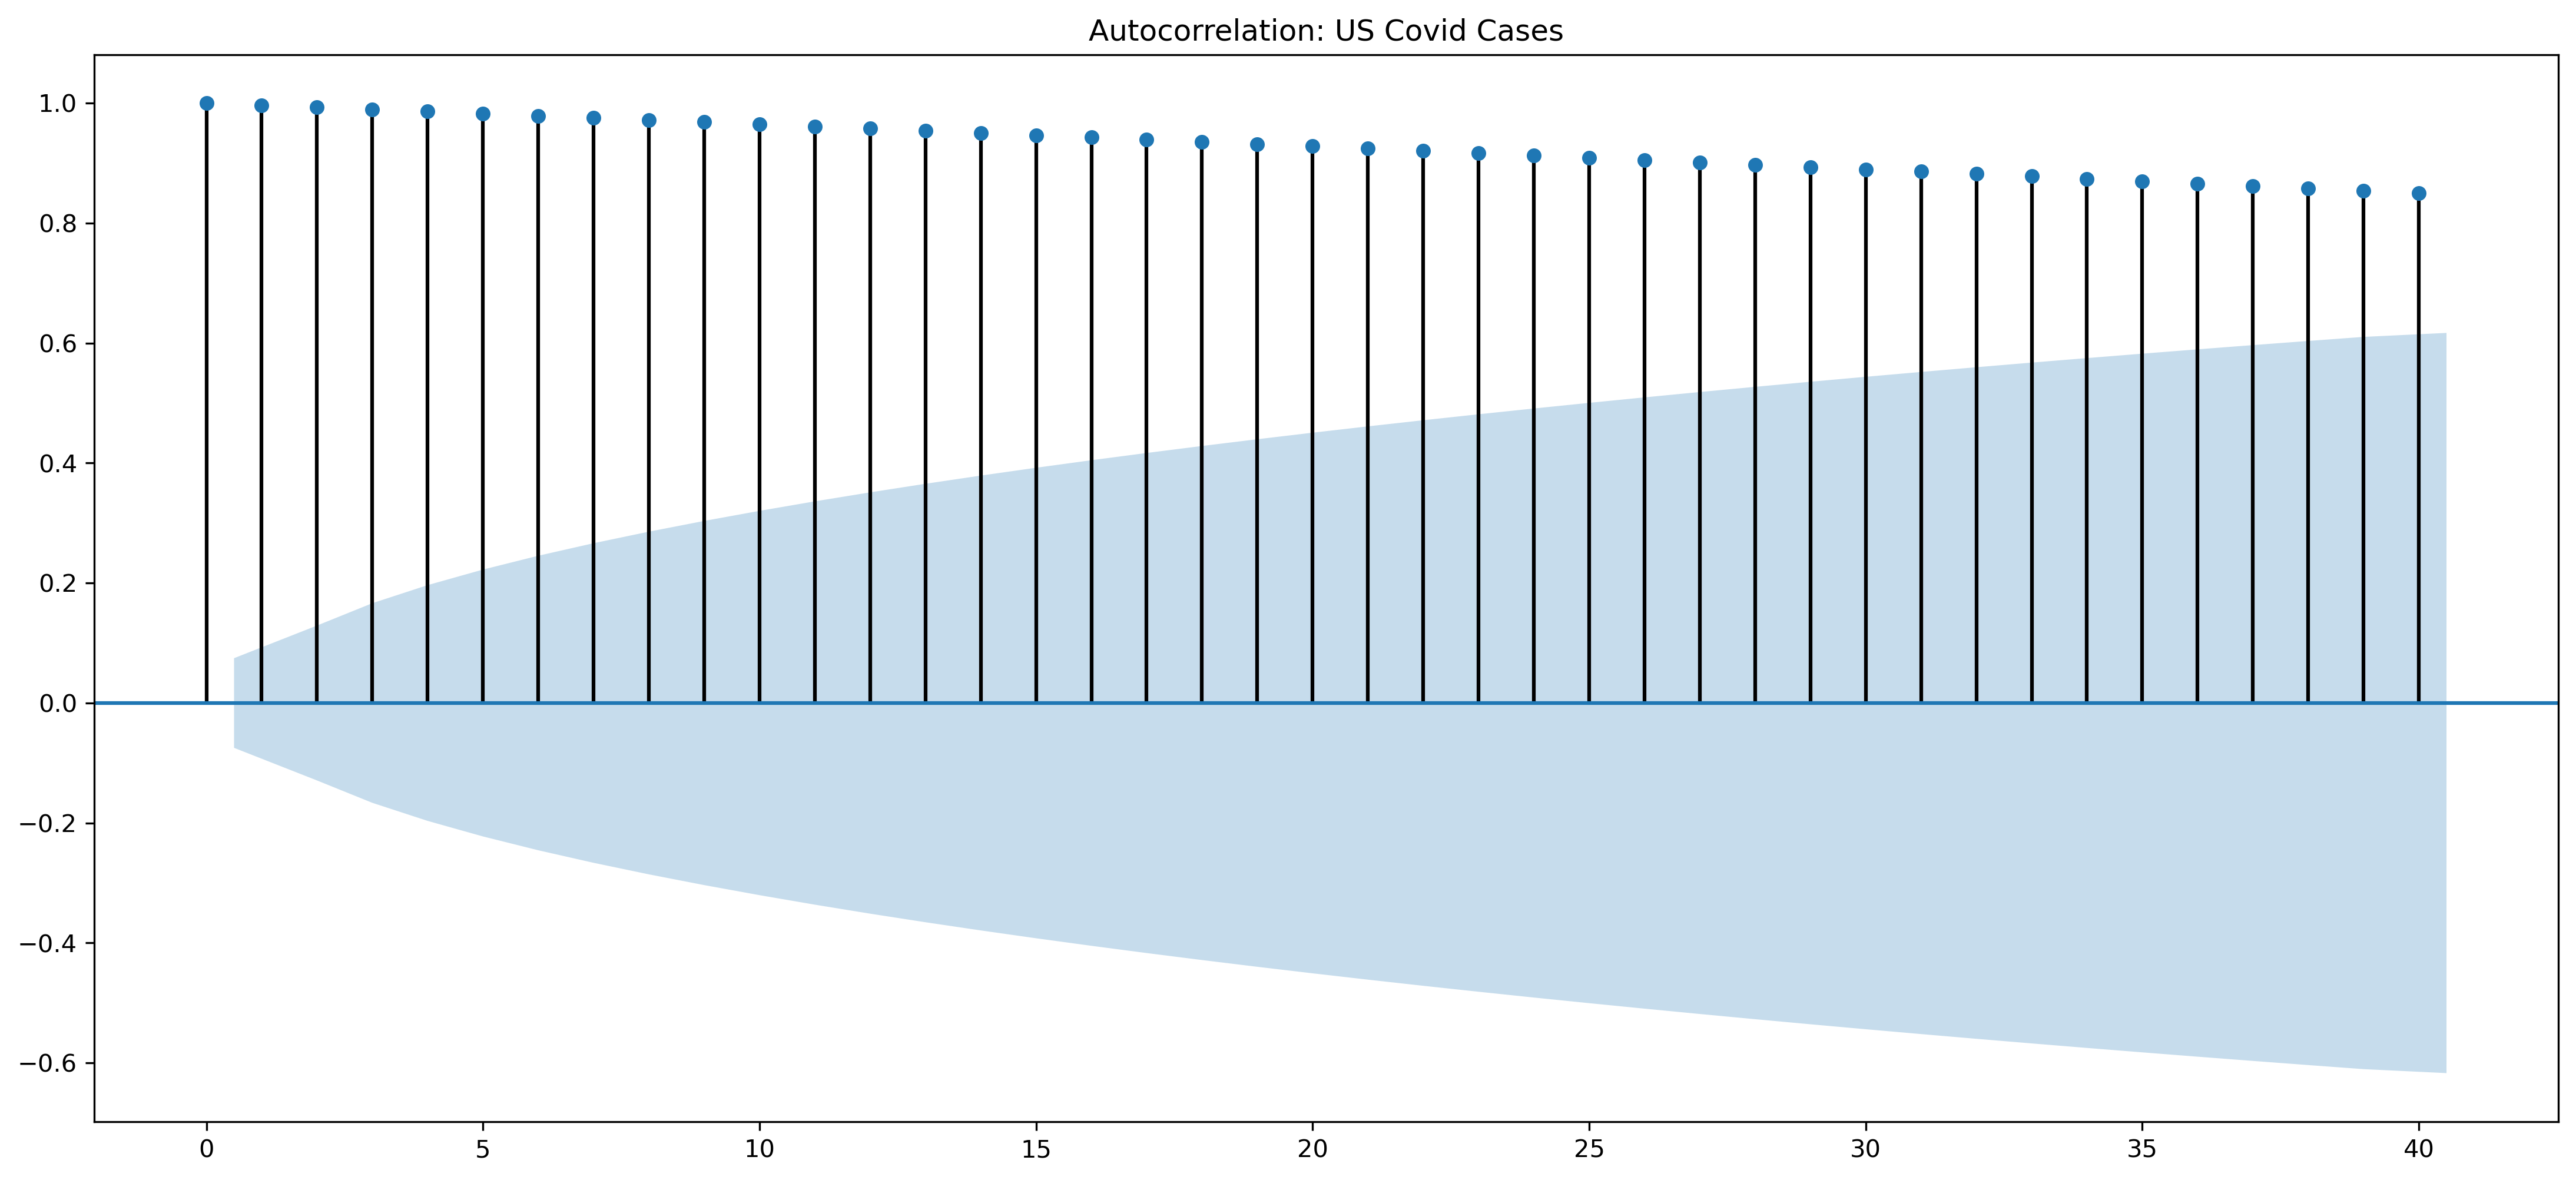

In [158]:
title = 'Autocorrelation: US Covid Cases'
lags = 40
plot_acf(df['cases'],title=title,lags=lags);

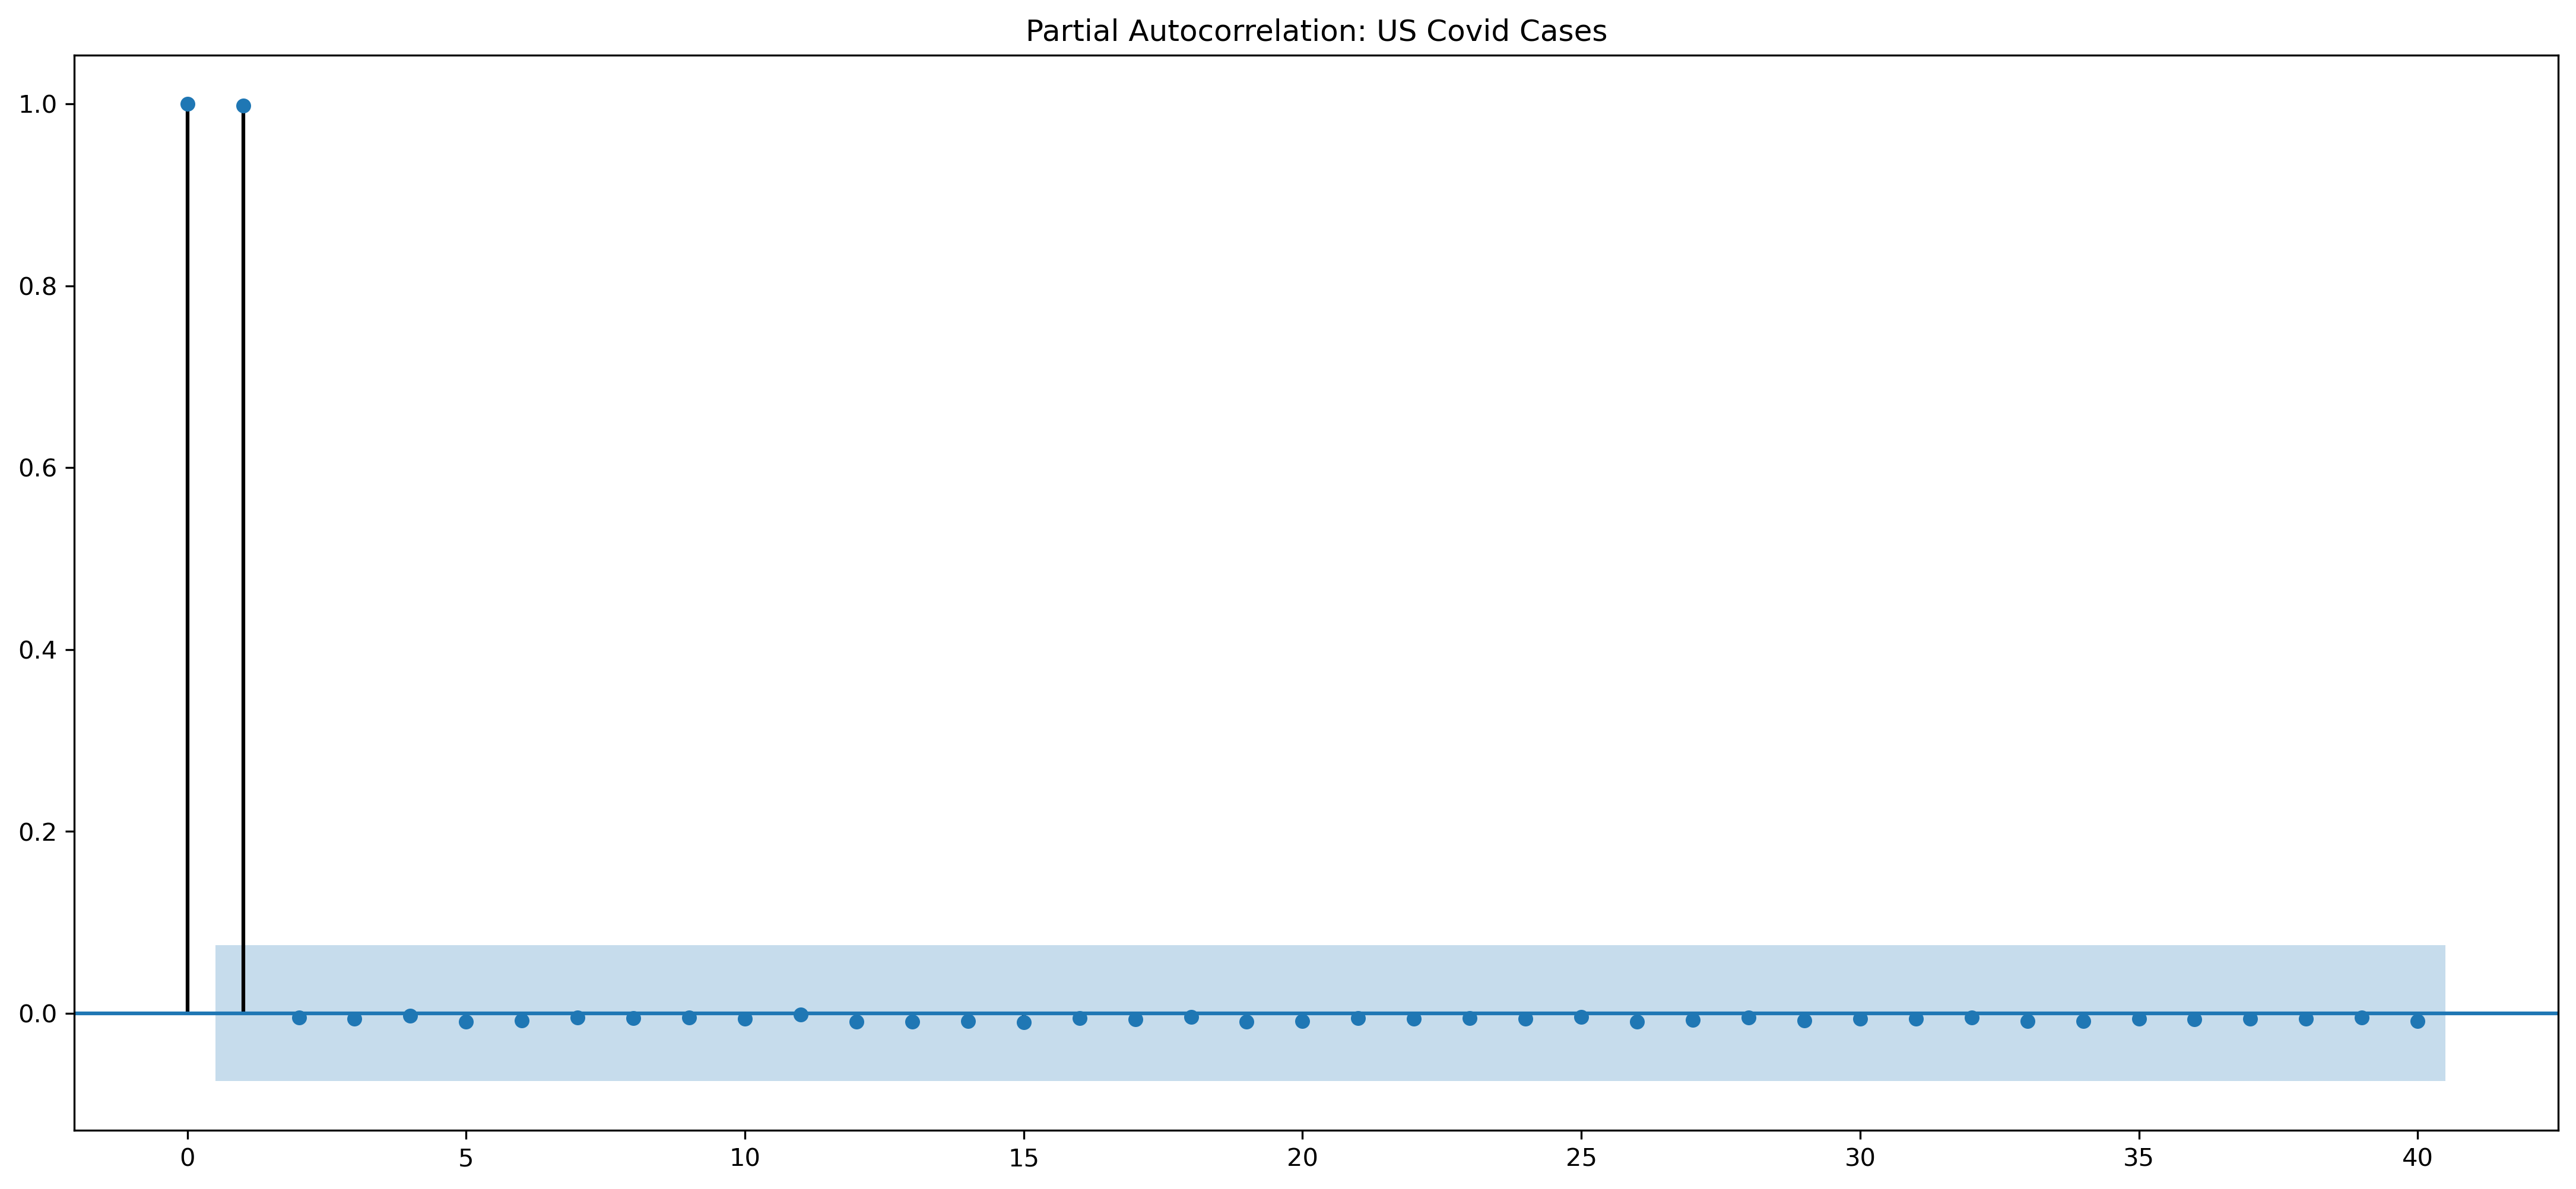

In [159]:
title = 'Partial Autocorrelation: US Covid Cases'
lags = 40
plot_pacf(df['cases'],title=title,lags=lags);

This tells us that the AR component should be more important than MA.

### Build ARIMA Model

In [160]:
# Set 50 days as test
l = len(df)
train = df.iloc[:l-50]
test = df.iloc[l-50:]

model = ARIMA(train['cases'],order=(3,2,3))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.cases   No. Observations:                  636
Model:                 ARIMA(3, 2, 3)   Log Likelihood               -7368.692
Method:                       css-mle   S.D. of innovations          25973.402
Date:                Thu, 09 Dec 2021   AIC                          14753.384
Time:                        16:46:12   BIC                          14789.026
Sample:                    01-23-2020   HQIC                         14767.222
                         - 10-19-2021                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            131.5769    259.389      0.507      0.612    -376.816     639.970
ar.L1.D2.cases    -0.1771      0.060     -2.936      0.003      -0.295      -0.059
ar.L2.D2.cases    -0.8781      0.029    -30.184      0.000      -0.935      -0.821
ar.L3.D2.cases     0.2304      0.054      4.273      0.000       0.125       0.336
ma.L1.D2.cases    -0.4967      0.049    -10.158      0.000      -0.593      -0.401
ma.L2.D2.cases     0.6810      0.034     20.302      0.000       0.615       0.747
ma.L3.D2.cases    -0.7273      0.026    -28.188      0.000      -0.778      -0.677
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2118           -0.9900j            1.0124           -0.2835
AR.2           -0.2118           +0.9900j            1.0124            0.2835
AR.3            4.2346           -0.0000j            4.2346           -0.0000
MA.1           -0.1619           -1.0319j            1.0445           -0.2748
MA.2           -0.1619           +1.0319j            1.0445            0.2748
MA.3            1.2602           -0.0000j            1.2602           -0.0000
-----------------------------------------------------------------------------
"""

In [161]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3,2,3) Predictions')

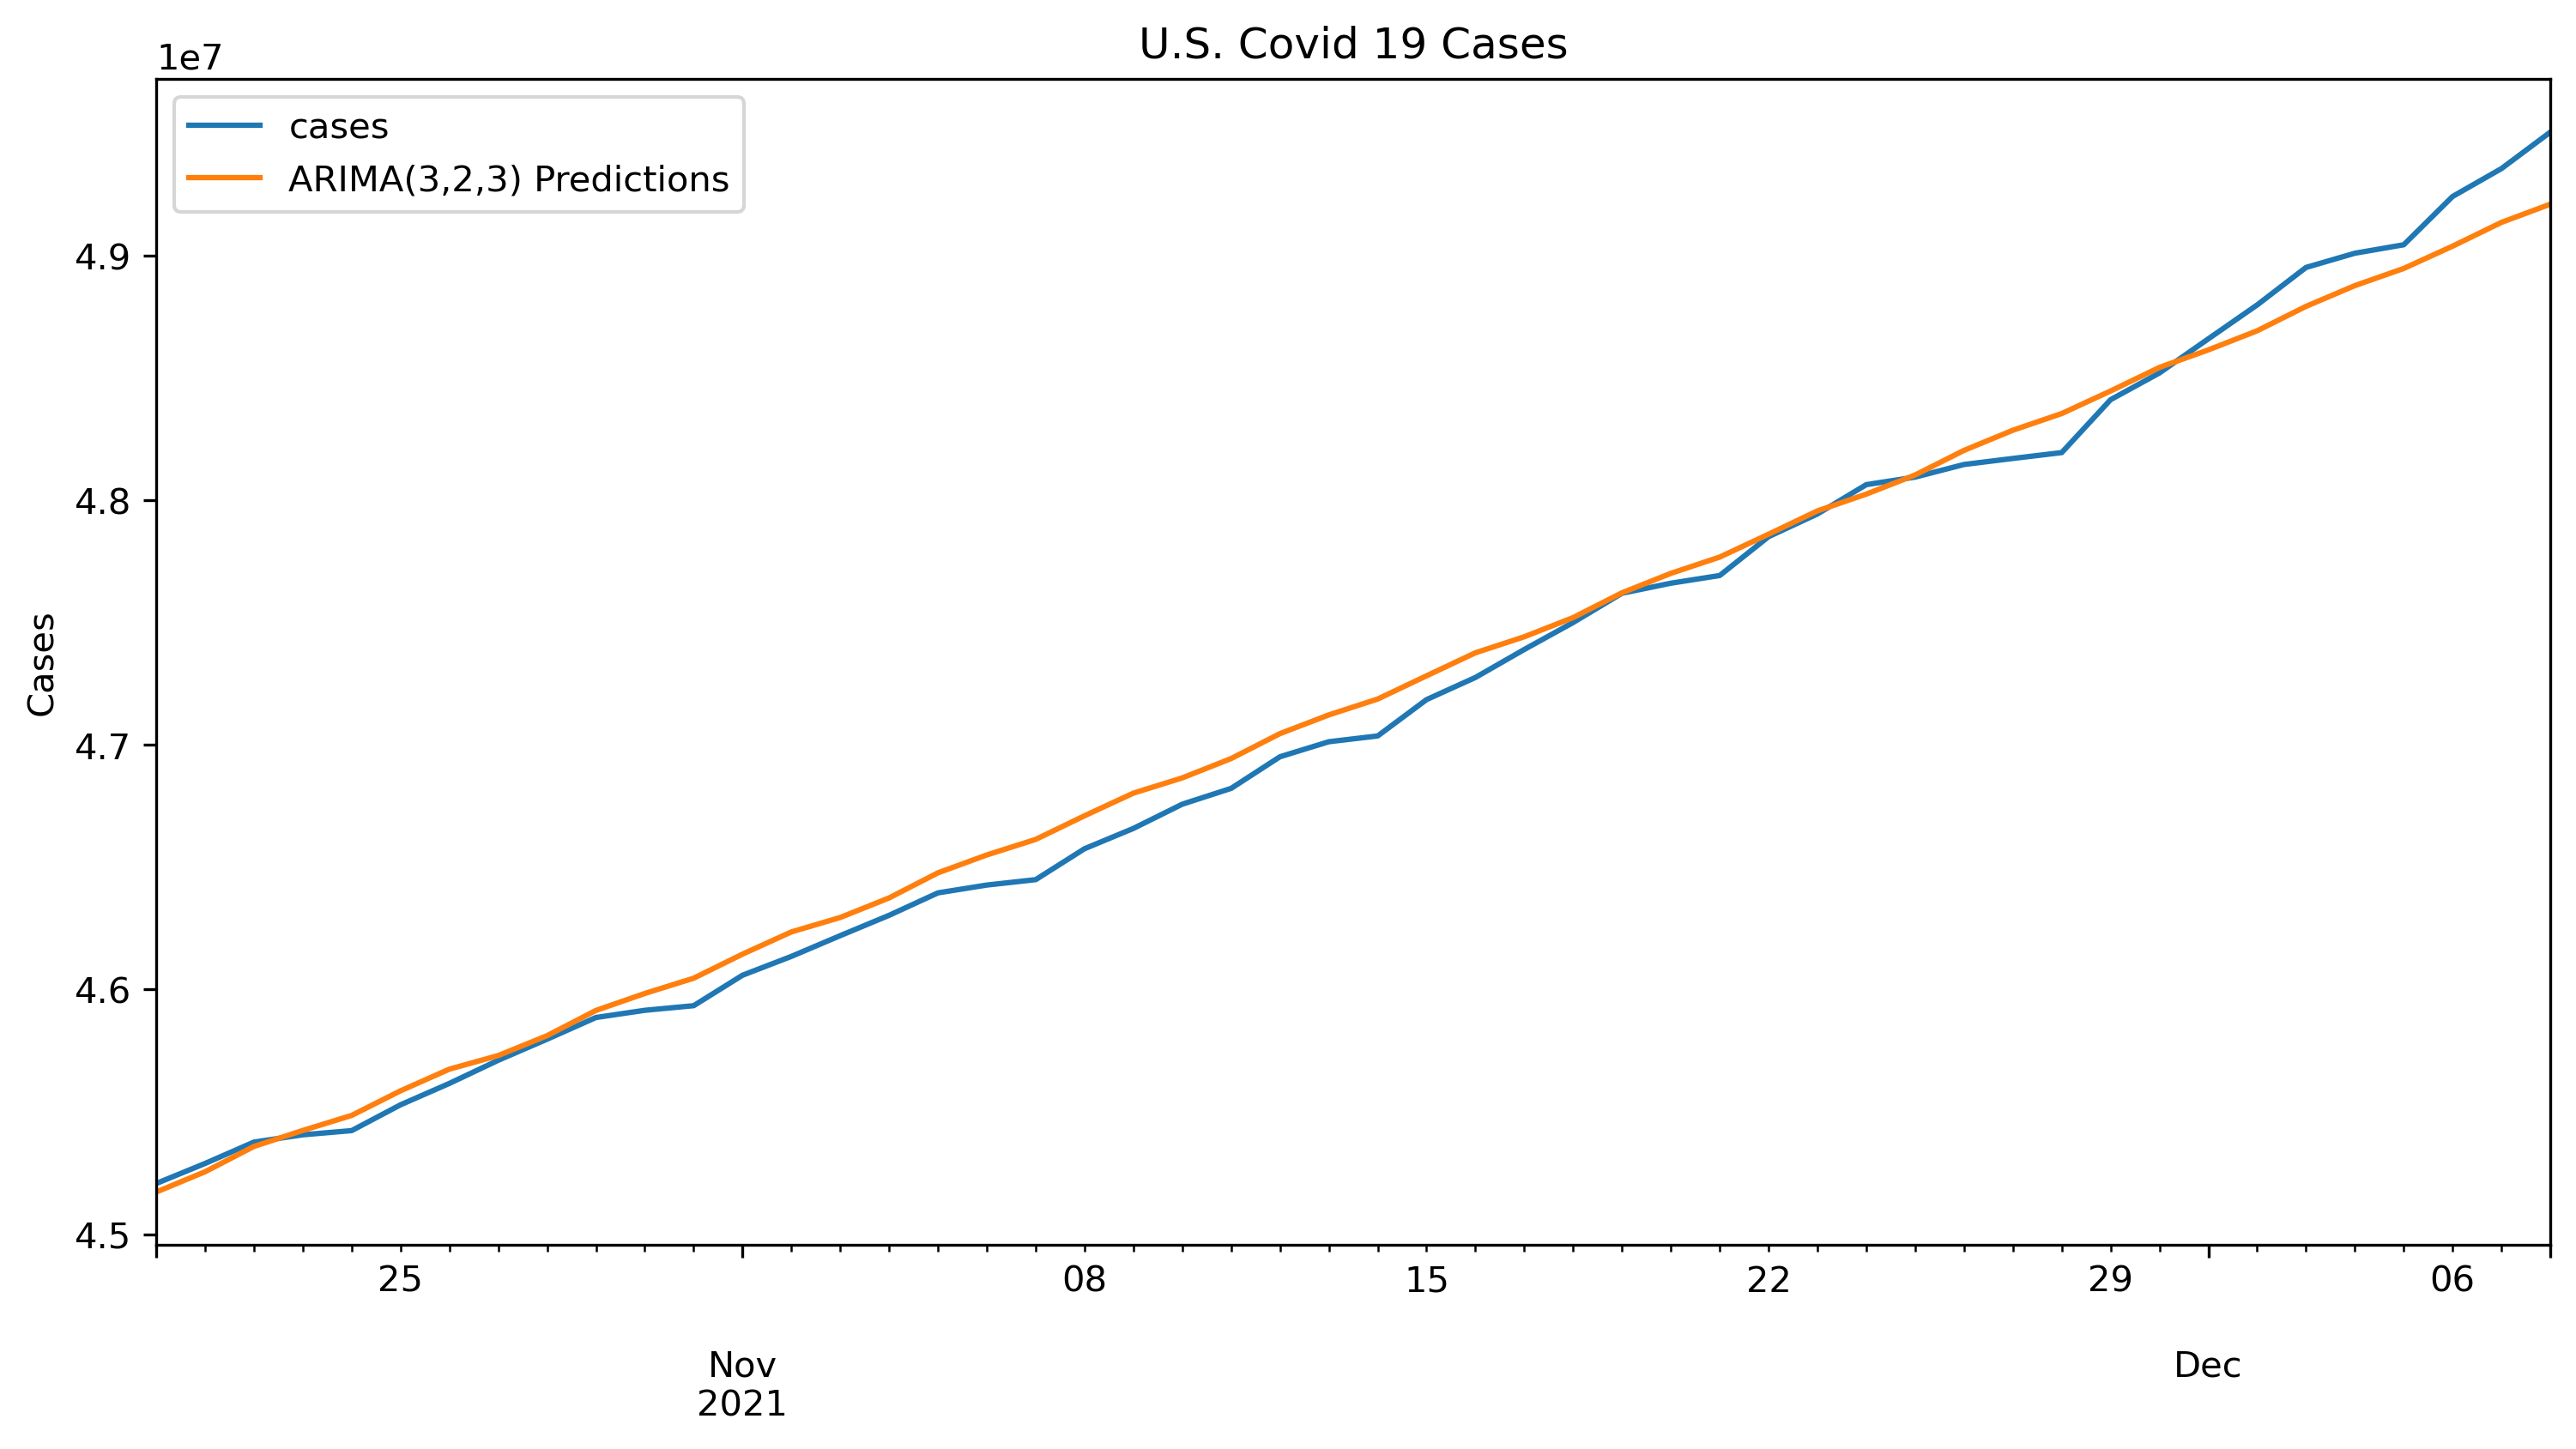

In [164]:
# Plot predictions against known values
title = 'U.S. Covid 19 Cases'
ylabel='Cases'
xlabel='' # we don't really need a label here

ax = test['cases'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

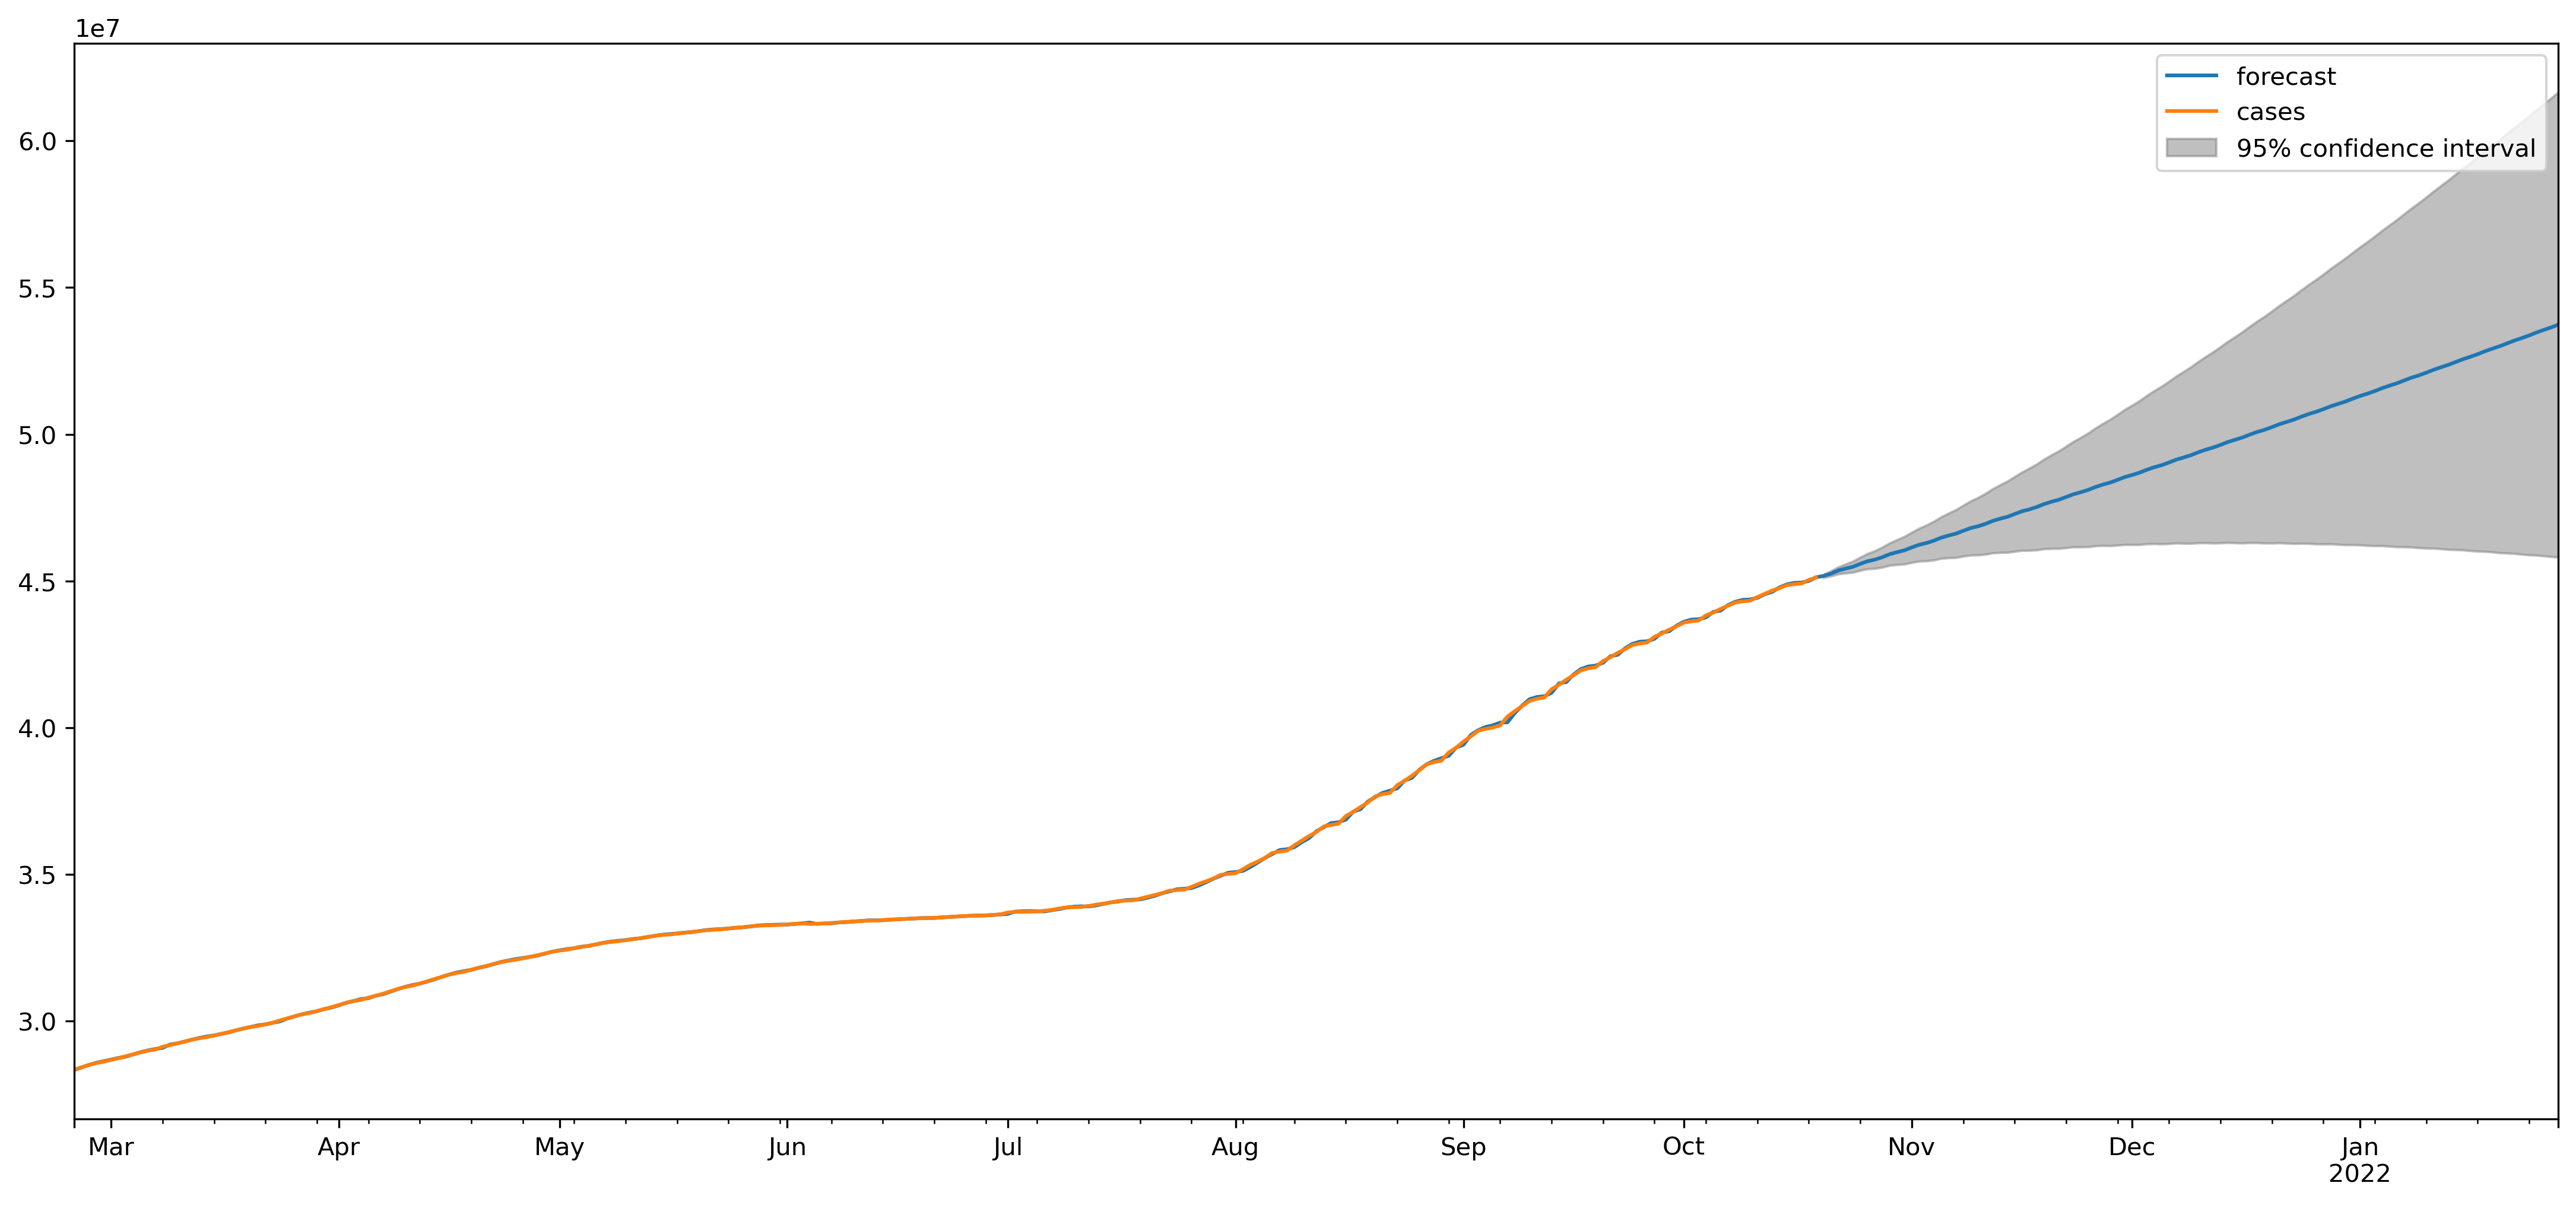

In [165]:
fcast = results.plot_predict(start = int(400), end = int(len(df)+50))

### Evaluation Metrics

In [166]:
error = int(np.sqrt(mean_squared_error(test.cases,predictions)))
mean = int(test.cases.mean())
error_rate = round((error/mean),5)
print(f'Error for test data is: {error}\n\
Mean for test data is: {mean}\n\
Error Rate is: {error_rate}\n')

Error for test data is: 103539
Mean for test data is: 47143878
Error Rate is: 0.0022



Error rate for ARIMA Model is 0.0022<br>
Error rate for DES Model is 0.00772<br>
So we will go with ARIMA model

### Retrain the model on the full data, and forecast the future

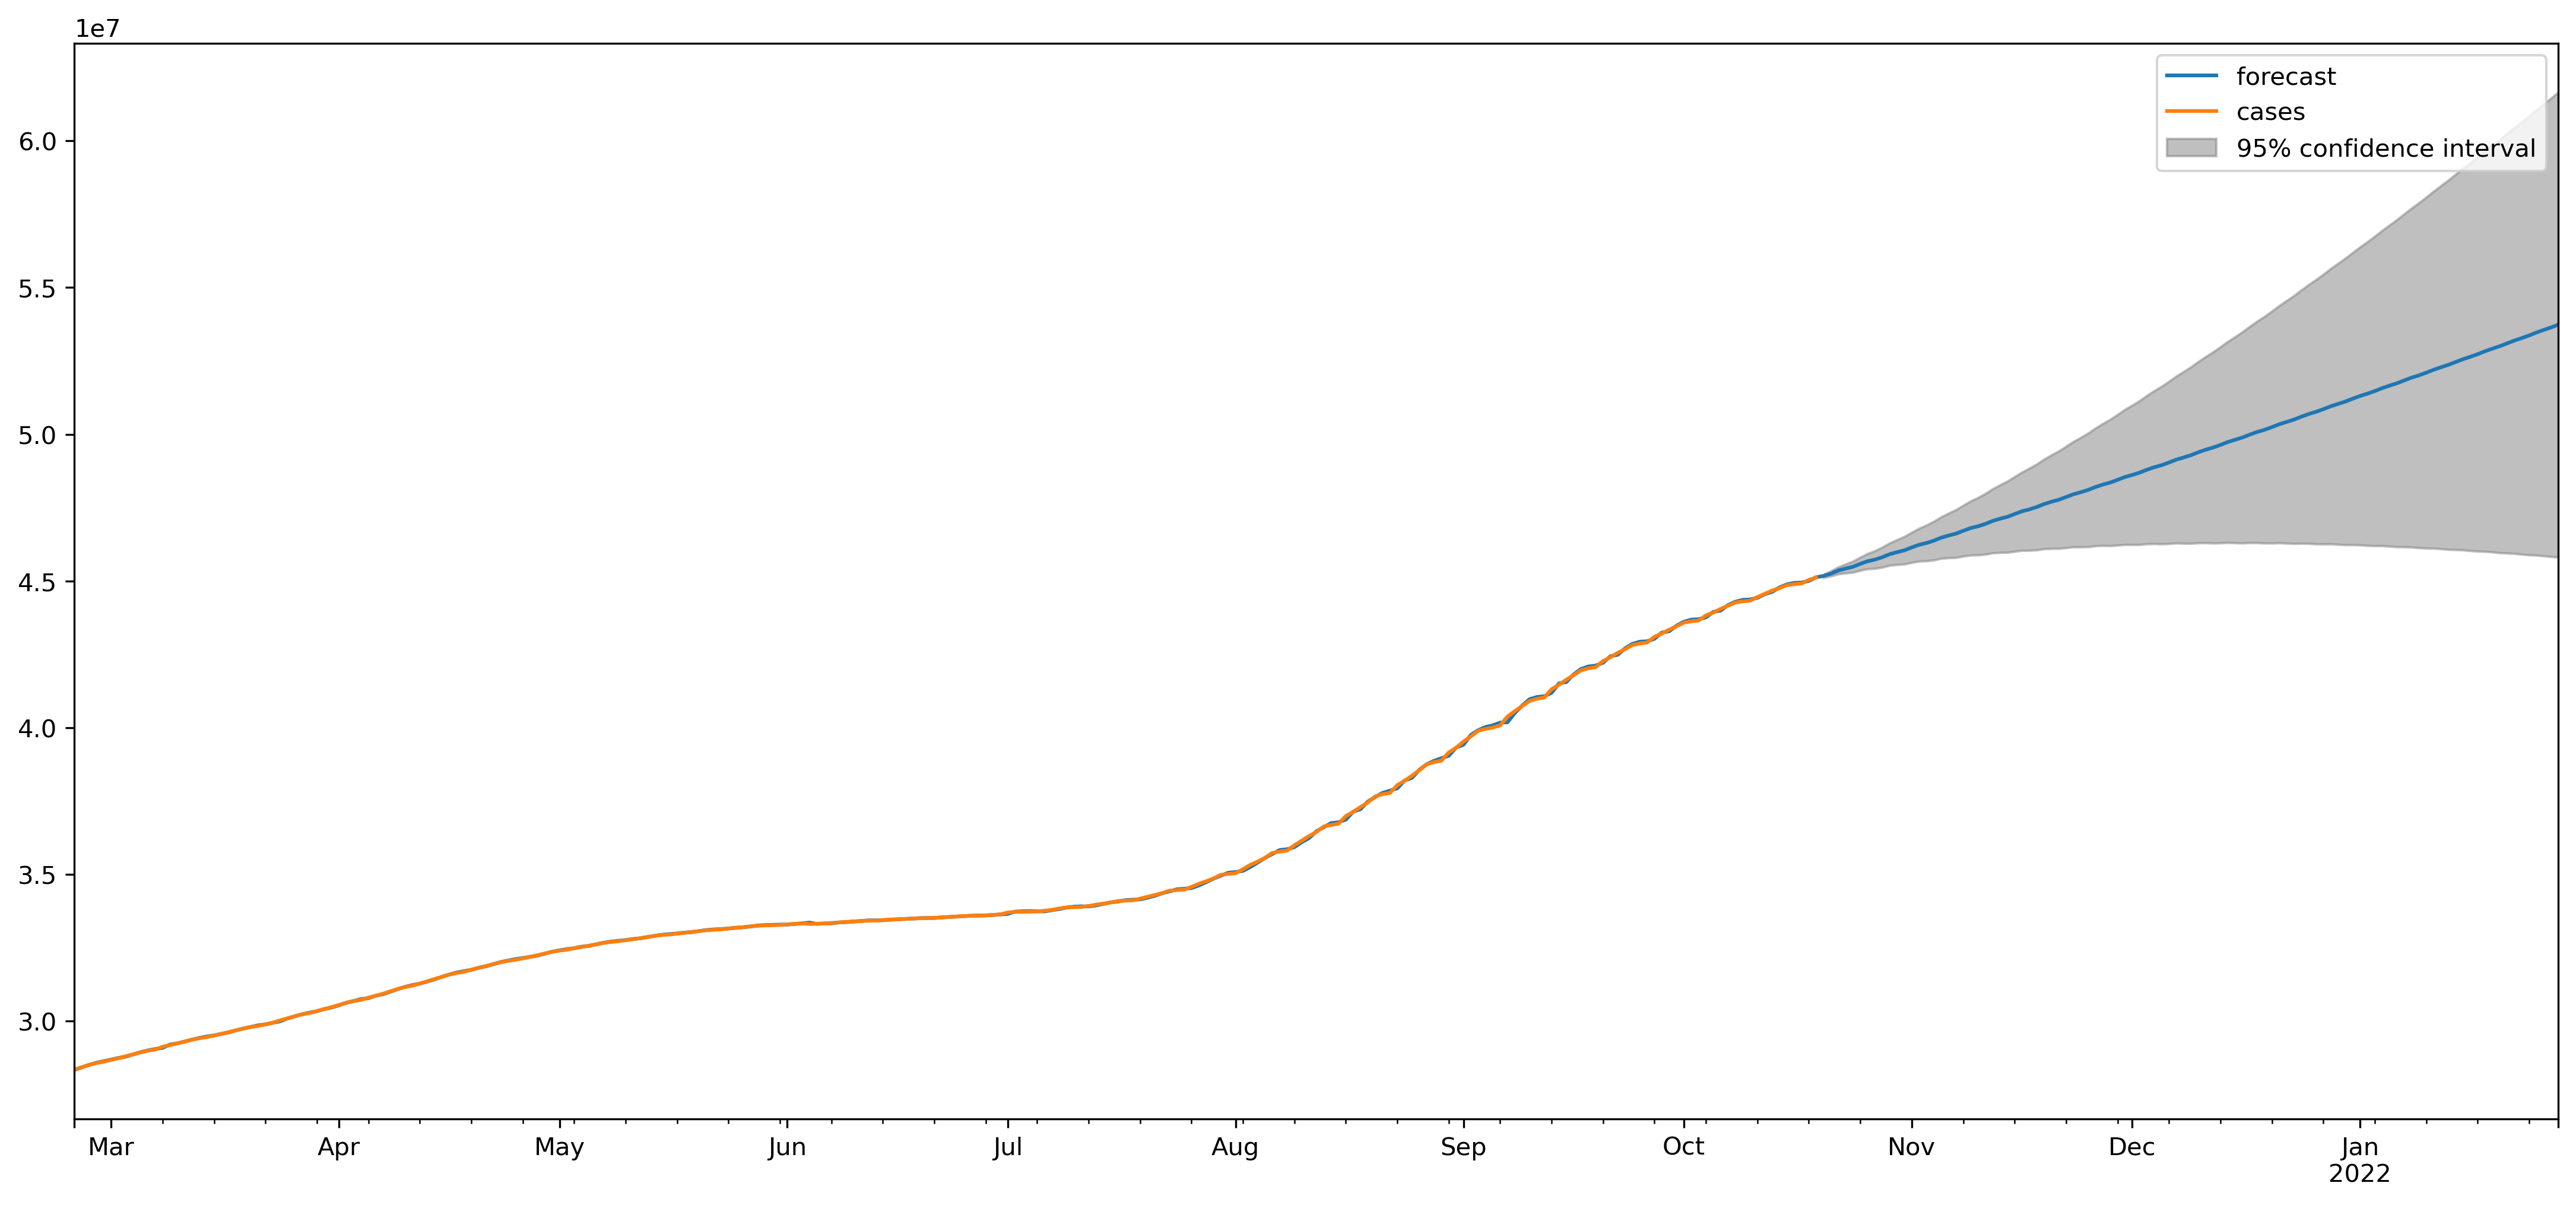

In [167]:
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv',index_col='date',parse_dates=True)

full_model = ARIMA(df['cases'],order=(3,2,3))
full_results = model.fit()
fcast = full_results.plot_predict(start = int(400), end = int(len(df)+50))

# Conclution

Even though we got 0.0022 error rate, we can see that as time go one, the confidence interval get larger and larger. Hence, we can only conlude that this model is suitable for short time interval in the future.<br>
Besides that, epidemics are often far more complex than we think, and there are many other factors such as vaccine production efficiency, population vaccination rates, virus mutations and so on that affect the accuracy of the model. For example, the novel coronavirus Omicron was recently discovered in South Africa. According to data released by the National Agency for Communicable Diseases in South Africa, 74% of the 249 confirmed coronavirus samples in the country were found to be Omicron. The country believes Omicron has rapidly replaced Delta as the dominant coronavirus in South Africa. In order to better predict the number of diagnoses, we need to adopt more variables and optimize the algorithm. At the same time, I firmly believe that with the passage of time and the development of technology, mankind will eventually overcome the epidemic and return to normal life!